In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from itertools import cycle
import seaborn as sns
import pickle as pkl

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

# Numbers for punzi - all models together

In [4]:
nbc_red = pkl.load(open('bdt_optimized_ntrk_no_mjj_ungr.pkl', 'rb'))
nbc_bin_red = pkl.load(open('bdt_bin_optimized_ntrk_no_mjj_ungr.pkl', 'rb'))

In [5]:
df_red = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df_red = pd.concat([df_red, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

data_red = df_red.drop(columns = ['lead_ungrs', 'sub_ungrs', 'mjjs', 'weights'])
data_red

,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ntrk,sub_ntrk,labels
0,0.039967,146.150787,0.525687,0.505117,-27.057099,-23.003627,0
1,1.387635,14.246826,-1.370057,0.113648,-47.325838,-42.513492,0
2,1.520813,94.611481,1.142746,-0.478356,-22.852907,-45.262825,0
3,1.955224,79.998779,-0.021801,1.994529,-22.796860,-39.182772,0
4,0.747826,97.815399,-0.216873,0.608687,-25.285624,-26.312875,0
...,...,...,...,...,...,...,...
2067579,1.818661,211.678955,0.903337,-0.919513,-16.311280,44.333506,4
2067580,0.938040,136.215576,0.324722,-0.615071,3.673315,-6.691277,4
2067581,0.264742,106.248535,0.488685,0.740875,126.251694,12.251655,4
2067582,1.310556,192.544434,-0.370099,0.945993,61.481212,17.241032,4


In [6]:
feats_red = data_red.iloc[:, :-1]
labels_red = data_red.labels
labels_bin_red = data_red.labels.replace([2, 3, 4], 1)
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(feats_red, labels_red, test_size=0.2, random_state=42)
_, _, y_train_bin_red, y_test_bin_red = train_test_split(feats_red, labels_bin_red, test_size=0.2, random_state=42)

In [7]:
x_train_scaled_red = MinMaxScaler().fit_transform(x_train_red)
x_test_scaled_red = MinMaxScaler().fit_transform(x_test_red)

In [58]:
probs_red = nbc_bin_red.predict_proba(x_test_scaled_red)
scaled_red = MinMaxScaler().fit_transform(probs_red)[:, 1]

In [9]:
scores_red = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]

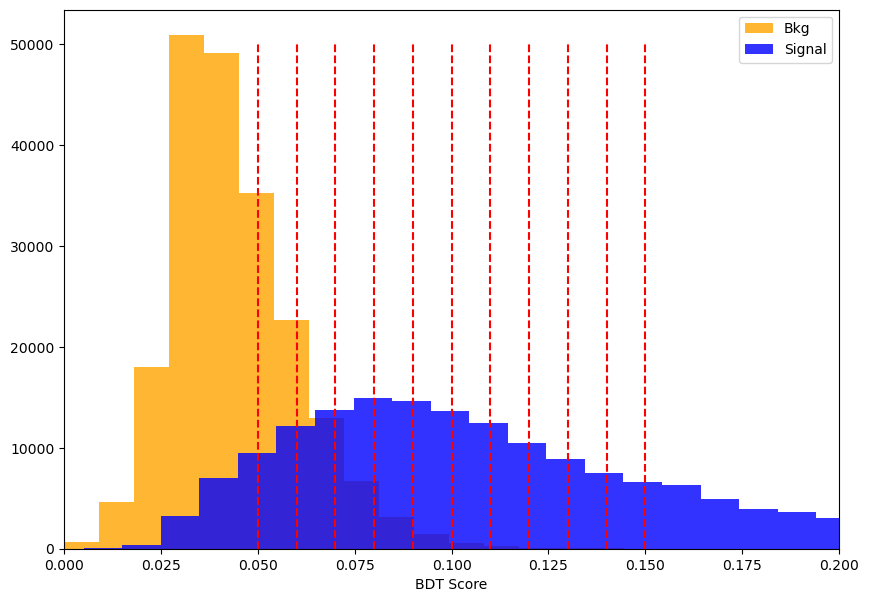

In [10]:
plt.figure(figsize=(10,7))
plt.hist(x=scaled_red[y_test_bin_red==0], color='orange', label = 'Bkg', bins=100, alpha=0.8)
plt.hist(x=scaled_red[y_test_bin_red==1], color='blue', label = 'Signal', bins=100, alpha=0.8)
for i in scores_red:
    plt.plot([i, i], [0, 50000], 'r--')
plt.xlim([0, 0.2])
plt.xlabel('BDT Score')
plt.legend()
plt.show()

In [11]:
scaler = MinMaxScaler()
x_test_scaled_red = scaler.fit_transform(x_test_red)

In [84]:
bkg_red = scaled_red[y_test_bin_red == 0]
sig_red = scaled_red[y_test_bin_red == 1]
scores_red = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]
for i in scores_red:
    score = str(i).split('.')[-1]
    try:
        bkg_idx = [j for j in range(len(bkg_red)) if bkg_red[j]>=i]
        np.save('x_test_bkg_red_%s_punzi.npy'%score, x_test_scaled_red[bkg_idx])
    except:
        print('bkg Didnae work for {}'.format(i))
    try:
        sig_idx = [k for k in range(len(sig_red)) if sig_red[k]>=i]
        x_test_red.iloc[sig_idx, :].to_csv('x_test_sig_red_%s_punzi.csv'%score)
    except:
        print('sig Didnae work for {}'.format(i))

# Punzi is TPR/[(a/2)+sqrt(N_bkg)]

In [106]:
signifs = {}
for i in scores_red:
    score = str(i).split('.')[-1]
    print(score)
    #bkg = np.load('x_test_bkg_red_%s_punzi.npy'%score)
    sig = pd.read_csv('x_test_sig_red_%s_punzi.csv'%score)
    signif = len(sig)/np.sqrt(len(sig)+len(bkg_red))
    signifs[score] = signif

04
05
06
07
08
09
1
11
12
13
14
15


In [107]:
signifs

{'04': 313.7516631732172,
 '05': 303.80575162528476,
 '06': 290.4106288940654,
 '07': 274.0755509035332,
 '08': 255.3674147984168,
 '09': 235.19485686800112,
 '1': 215.4640890989386,
 '11': 196.68427486726105,
 '12': 179.84747917338058,
 '13': 165.00171373259448,
 '14': 151.94589008949686,
 '15': 140.77567278705246}

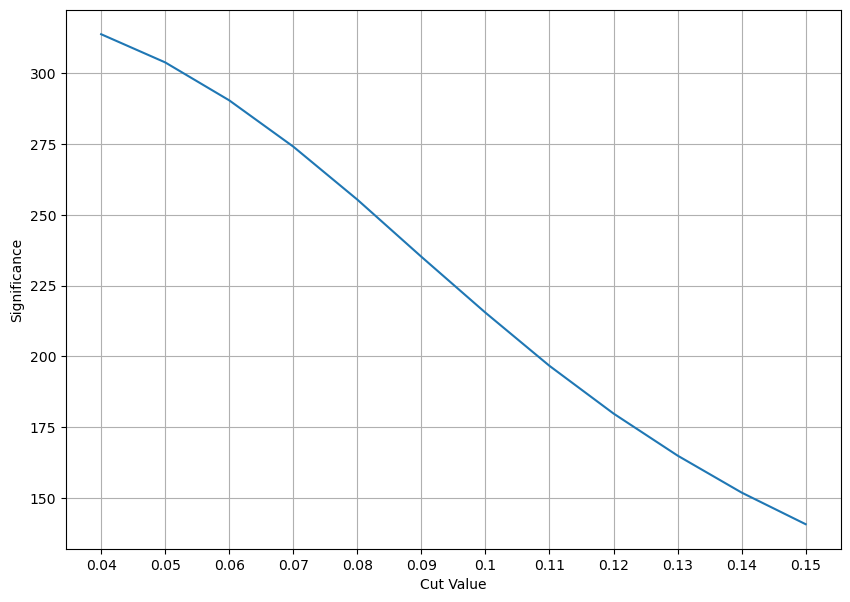

In [108]:
plt.figure(figsize=(10,7))
plt.plot(signifs.values())
plt.xticks(np.arange(0, len(signifs.values())), scores_red)
plt.grid()
plt.xlabel('Cut Value')
plt.ylabel('Significance')
plt.show()

In [109]:
punzis = {}
for i in scores_red:
    score = str(i).split('.')[-1]
    print(score)
    #bkg = np.load('x_test_bkg_red_%s_punzi.npy'%score)
    sig = pd.read_csv('x_test_sig_red_%s_punzi.csv'%score)
    sig_scaled = MinMaxScaler().fit_transform(sig.iloc[:, 1:])
    probs = nbc_bin_red.predict(sig_scaled)
    true = y_test_bin_red[sig['Unnamed: 0'].values].values
    n = 0
    for i in range(len(probs)):
        if probs[i]==true[i]:
            n+=1
    sig_eff = n/len(sig)
    punzi = sig_eff/((3/2)+np.sqrt(len(bkg_red)))
    punzis[score] = punzi

04
05
06
07
08
09
1
11
12
13
14
15


In [110]:
punzis

{'04': 0.0018753417314602433,
 '05': 0.0018759468011764957,
 '06': 0.001876007374995612,
 '07': 0.0018766974741981281,
 '08': 0.001876012363328182,
 '09': 0.0018755456550942004,
 '1': 0.0018744694115137468,
 '11': 0.0018740579019740219,
 '12': 0.0018740455765308922,
 '13': 0.0018749962266199648,
 '14': 0.0018737483700515206,
 '15': 0.0018728770454470435}

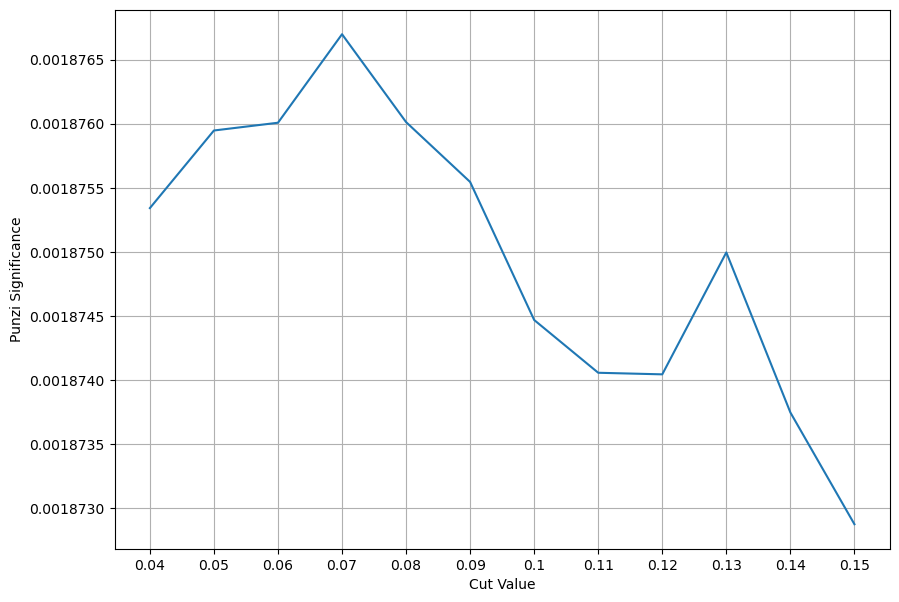

In [111]:
plt.figure(figsize=(10,7))
plt.plot(punzis.values())
plt.xticks(np.arange(0, len(punzis.values())), scores_red)
plt.grid()
plt.xlabel('Cut Value')
plt.ylabel('Punzi Significance')
plt.show()

# Punzi stuff for 4x7 values (ModelxValue)

In [2]:
df = pd.read_csv('df_bkg_red_vals_new.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red_vals_newest.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [3]:
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,vals,lead_ntrk,sub_ntrk,labels
0,1888.168945,1.829987,201.025452,0.839641,-1.037925,31,37,1000,-40.242415,-42.777139,0
1,2389.667480,2.411867,3.136414,1.571662,-0.880877,52,55,1000,-21.474150,-28.299496,0
2,1293.717407,0.340623,10.156311,-0.436375,-0.096425,34,23,1000,-32.641184,-50.163837,0
3,1986.557251,1.809374,59.459229,1.076468,-0.814361,41,37,1000,-30.780724,-43.602455,0
4,1270.481201,0.580307,226.615509,-0.263168,0.367645,50,65,1000,-16.408087,-7.843346,0
...,...,...,...,...,...,...,...,...,...,...,...
2654995,2686.224854,1.818661,211.678955,0.903337,-0.919513,58,129,3500,-16.311280,44.333506,4
2654996,2692.715088,0.938040,136.215576,0.324722,-0.615071,78,78,3500,3.673315,-6.691277,4
2654997,2476.301514,0.264742,106.248535,0.488685,0.740875,200,96,3500,126.251694,12.251655,4
2654998,2140.740234,1.310556,192.544434,-0.370099,0.945993,134,99,3500,61.481212,17.241032,4


In [4]:
master = df.drop(columns = ['lead_ungrs', 'sub_ungrs', 'mjjs', 'vals'])
master.insert(6, 'vals', df.vals)
master

,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ntrk,sub_ntrk,vals,labels
0,1.829987,201.025452,0.839641,-1.037925,-40.242415,-42.777139,1000,0
1,2.411867,3.136414,1.571662,-0.880877,-21.474150,-28.299496,1000,0
2,0.340623,10.156311,-0.436375,-0.096425,-32.641184,-50.163837,1000,0
3,1.809374,59.459229,1.076468,-0.814361,-30.780724,-43.602455,1000,0
4,0.580307,226.615509,-0.263168,0.367645,-16.408087,-7.843346,1000,0
...,...,...,...,...,...,...,...,...
2654995,1.818661,211.678955,0.903337,-0.919513,-16.311280,44.333506,3500,4
2654996,0.938040,136.215576,0.324722,-0.615071,3.673315,-6.691277,3500,4
2654997,0.264742,106.248535,0.488685,0.740875,126.251694,12.251655,3500,4
2654998,1.310556,192.544434,-0.370099,0.945993,61.481212,17.241032,3500,4


In [8]:
feats = data.iloc[:, :-1]
labels = data.labels
labels_bin = data.labels.replace([2, 3, 4], 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(feats, labels, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(feats, labels_bin, test_size=0.2, random_state=42)

In [10]:
x_train_scaled = MinMaxScaler().fit_transform(x_train.iloc[:, :-1])
x_test_scaled = MinMaxScaler().fit_transform(x_test.iloc[:, :-1])

In [8]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=60,
                            min_samples_leaf=0.05,
                           min_samples_split=0.78,
                             )
nbc = AdaBoostClassifier(tree, 
                         learning_rate=0.73,#optimizer.max["params"]['learning_rate'], 
                         n_estimators=200,
                        )#best_params['n_estimators'])
nbc_bin = AdaBoostClassifier(tree, 
                         learning_rate=0.67, 
                         n_estimators=800)

In [9]:
nbc.fit(x_train_scaled, y_train)
nbc_bin.fit(x_train_scaled, y_train_bin)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=60,
                                                    min_samples_leaf=0.05,
                                                    min_samples_split=0.7750326118336215),
                   learning_rate=0.67, n_estimators=800)

In [7]:
#pkl.dump(nbc, open('bdt_punzi.pkl', 'wb'))
#pkl.dump(nbc_bin, open('bdt_bin_punzi.pkl', 'wb'))
nbc = pkl.load(open('bdt_punzi.pkl', 'rb'))
nbc_bin = pkl.load(open('bdt_bin_punzi.pkl', 'rb'))

In [15]:
data_1500 = data.loc[(data.vals == 1000) | (data.vals == 1500)]
data_1500

,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ntrk,sub_ntrk,vals,labels
0,1.829987,201.025452,0.839641,-1.037925,-40.242415,-42.777139,1000,0
1,2.411867,3.136414,1.571662,-0.880877,-21.474150,-28.299496,1000,0
2,0.340623,10.156311,-0.436375,-0.096425,-32.641184,-50.163837,1000,0
3,1.809374,59.459229,1.076468,-0.814361,-30.780724,-43.602455,1000,0
4,0.580307,226.615509,-0.263168,0.367645,-16.408087,-7.843346,1000,0
...,...,...,...,...,...,...,...,...
2409913,0.746234,113.336487,0.685395,-0.063133,13.969618,2.673928,1500,4
2409914,0.628538,45.410614,-0.188613,0.463462,28.909946,-3.048178,1500,4
2409915,0.194631,47.990234,0.331587,0.551242,17.642414,-9.155406,1500,4
2409916,1.472417,69.878540,0.082522,-1.412394,-14.043301,40.656276,1500,4


In [16]:
data_1500_a = data_1500.loc[(data_1500.labels == 0) | (data_1500.labels == 1)]
data_1500_a

,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ntrk,sub_ntrk,vals,labels
0,1.829987,201.025452,0.839641,-1.037925,-40.242415,-42.777139,1000,0
1,2.411867,3.136414,1.571662,-0.880877,-21.474150,-28.299496,1000,0
2,0.340623,10.156311,-0.436375,-0.096425,-32.641184,-50.163837,1000,0
3,1.809374,59.459229,1.076468,-0.814361,-30.780724,-43.602455,1000,0
4,0.580307,226.615509,-0.263168,0.367645,-16.408087,-7.843346,1000,0
...,...,...,...,...,...,...,...,...
1364997,0.218938,156.791443,0.414159,0.633233,-0.978628,-15.629610,1500,1
1364998,0.053477,47.820496,0.980815,1.034417,-19.410573,-7.846760,1500,1
1364999,1.337124,28.195984,-1.865500,-0.520823,-22.732866,-26.290169,1500,1
1365000,1.213285,55.349213,-1.464260,-0.237506,-11.406953,-21.477362,1500,1


In [18]:
feats_1500_a = data_1500_a.iloc[:, :-2]
labels_1500_a = data_1500_a.labels
labels_bin_1500_a = data_1500_a.labels.replace([2, 3, 4], 1)
x_train_1500_a, x_test_1500_a, y_train_1500_a, y_test_1500_a = train_test_split(feats_1500_a, labels_1500_a, test_size=0.2, random_state=42)
_, _, y_train_bin_1500_a, y_test_bin_1500_a = train_test_split(feats_1500_a, labels_bin_1500_a, test_size=0.2, random_state=42)

In [19]:
x_train_scaled_1500_a = MinMaxScaler().fit_transform(x_train_1500_a)
x_test_scaled_1500_a = MinMaxScaler().fit_transform(x_test_1500_a)

In [24]:
probs_1500_a = nbc.predict_proba(x_test_scaled_1500_a)
scaled_1500_a = MinMaxScaler().fit_transform(probs_1500_a)[:, 1]

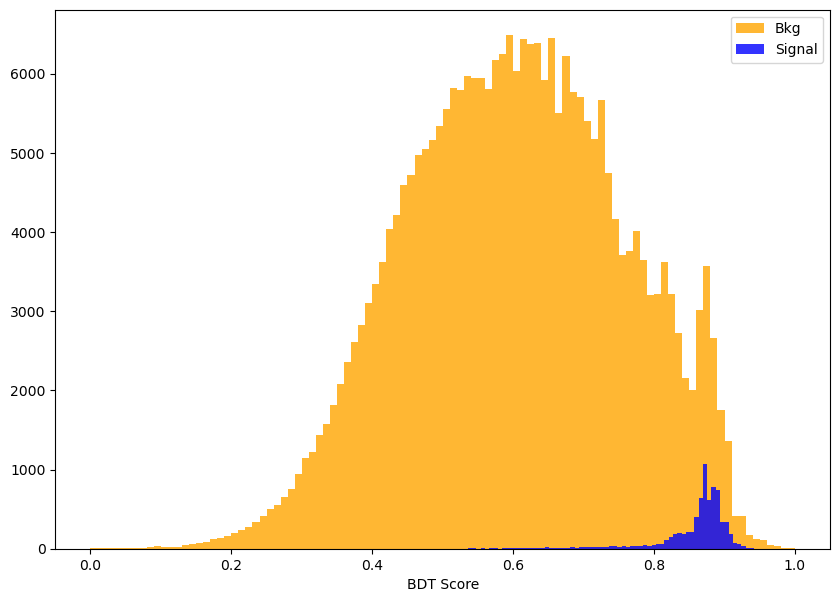

In [25]:
plt.figure(figsize=(10,7))
plt.hist(x=scaled_1500_a[y_test_bin_1500_a==0], color='orange', label = 'Bkg', bins=100, alpha=0.8)
plt.hist(x=scaled_1500_a[y_test_bin_1500_a==1], color='blue', label = 'Signal', bins=100, alpha=0.8)
scores_vals = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for i in scores_vals:
    plt.plot([i, i], [0, 50000], 'r--')
plt.xlim([0, 0.2])
plt.xlabel('BDT Score')
plt.legend()
plt.show()

In [26]:
scaler = MinMaxScaler()
x_test_scaled_1500_a = scaler.fit_transform(x_test_1500_a)

In [34]:
scores_1500_a = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [35]:
bkg_1500_a = scaled_1500_a[y_test_1500_a == 0]
sig_1500_a = scaled_1500_a[y_test_1500_a == 1]
for i in scores_1500_a:
    score = str(i).split('.')[-1]
    try:
        bkg_idx = [j for j in range(len(bkg_1500_a)) if bkg_1500_a[j]>=i]
        np.save('x_test_bkg_1500_a_%s_punzi.npy'%score, x_test_scaled_1500_a[bkg_idx])
    except:
        print('bkg Didnae work for {}'.format(i))
    try:
        sig_idx = [k for k in range(len(sig_1500_a)) if sig_1500_a[k]>=i]
        x_test_1500_a.iloc[sig_idx, :].to_csv('x_test_sig_1500_a_%s_punzi.csv'%score)
    except:
        print('sig Didnae work for {}'.format(i))

In [36]:
punzis_1500_a = {}
for i in scores_1500_a:
    score = str(i).split('.')[-1]
    print(score)
    sig = pd.read_csv('x_test_sig_1500_a_%s_punzi.csv'%score)
    sig_scaled = MinMaxScaler().fit_transform(sig.iloc[:, 1:])
    probs = nbc.predict(sig_scaled)
    true = y_test_1500_a[sig['Unnamed: 0'].values].values
    n = 0
    for i in range(len(probs)):
        if probs[i]==true[i]:
            n+=1
    sig_eff = n/len(sig)
    punzi = sig_eff/((3/2)+np.sqrt(len(bkg_1500_a)))
    punzis_1500_a[score] = punzi

6
65
7
75
8
85
9
95


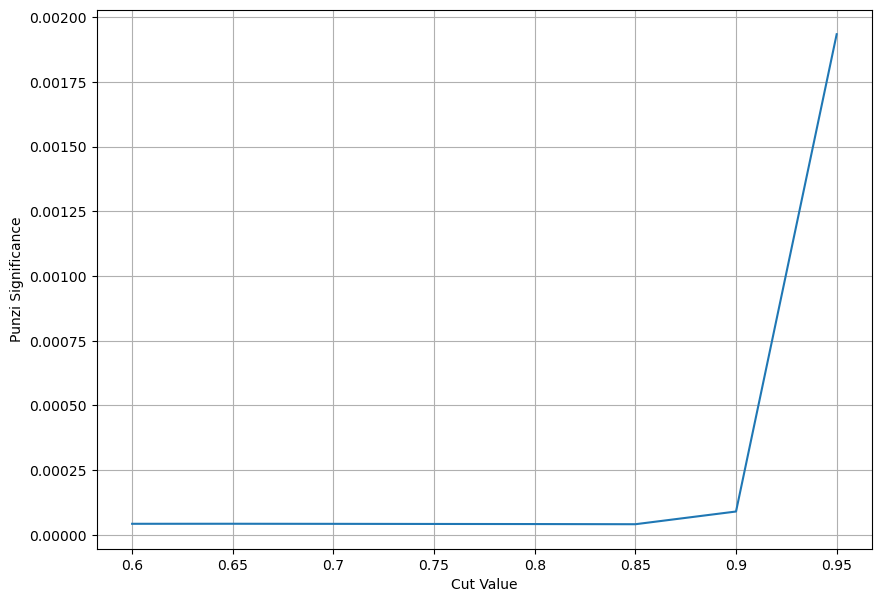

In [37]:
plt.figure(figsize=(10,7))
plt.plot(punzis_1500_a.values())
plt.xticks(np.arange(0, len(punzis_1500_a.values())), scores_1500_a)
plt.grid()
plt.xlabel('Cut Value')
plt.ylabel('Punzi Significance')
plt.show()

# Functionise this

In [41]:
data.vals.unique()[1:]

array([1500, 1750, 2000, 2250, 2500, 3000, 3500], dtype=int64)

In [12]:
models = ['bkg', 'A', 'B', 'C', 'D']
nums = [1, 2, 3, 4]
def fourxseven(master = master):
    print(master.vals.unique())
    for i in master.vals.unique()[1:]:
        data_val = master.loc[(master.vals == 1000) | (master.vals == i)]
        for num in nums:
            print('Val: %d\nModel: %s'%(i, models[num]))
            data = data_val.loc[(data_val.labels == 0) | (data_val.labels == num)]
            feats = data.iloc[:, :-2]
            labels = data.labels.replace([2, 3, 4], 1)
            x_train, x_test, y_train, y_test = train_test_split(feats, labels, test_size=0.2, random_state=42)
            #_, _, y_train_bin, y_test_bin = train_test_split(feats, labels_bin, test_size=0.2, random_state=42)
            x_train_scaled = MinMaxScaler().fit_transform(x_train)
            x_test_scaled = MinMaxScaler().fit_transform(x_test)
            probs = nbc.predict_proba(x_test_scaled)
            scaled = MinMaxScaler().fit_transform(probs)[:, 1]
            
            plt.figure(figsize=(10,7))
            plt.hist(x=scaled[y_test==0], color='orange', label = 'Bkg', bins=100, alpha=0.8)
            plt.hist(x=scaled[y_test==1], color='blue', label = 'Signal', bins=100, alpha=0.8)
            scores_vals = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
            #for k in scores_vals:
            #    plt.plot([k, k], [0, 50000], 'r--')
            plt.xlabel('BDT Score')
            plt.legend()
            plt.show()
            
            bkg = scaled[y_test == 0]
            sig = scaled[y_test == 1]
            for j in scores_vals:
                score = str(j).split('.')[-1]
                try:
                    bkg_idx = [m for m in range(len(bkg)) if bkg[m]>=j]
                    np.save('punzi/%s/x_test_bkg_%d_%s_%s_punzi.npy'%(models[num], i, models[num], score), x_test_scaled[bkg_idx])
                except:
                    print('bkg Didnae work for {} {} {}'.format(i, models[num], j))
                try:
                    sig_idx = [n for n in range(len(sig)) if sig[n]>=j]
                    x_test.iloc[sig_idx, :].to_csv('punzi/%s/x_test_sig_%d_%s_%s_punzi.npy'%(models[num], i, models[num], score))
                except:
                    print('sig Didnae work for {} {} {}'.format(i, models[num], j))
            
            punzis = {}
            for j in scores_vals:
                score = str(j).split('.')[-1]
                #print(score)
                try:
                    sig = pd.read_csv('punzi/%s/x_test_sig_%d_%s_%s_punzi.npy'%(models[num], i, models[num], score))
                    sig_scaled = MinMaxScaler().fit_transform(sig.iloc[:, 1:])
                except:
                    print('Not working: punzi/%s/x_test_sig_%d_%s_%s_punzi.npy'%(models[num], i, models[num], score))
                    continue
                probs = nbc.predict(sig_scaled)
                true = y_test[sig['Unnamed: 0'].values].values
                n = 0
                for v in range(len(probs)):
                    if probs[v]==true[v]:
                        n+=1
                sig_eff = n/len(sig)
                punzi = sig_eff/((3/2)+np.sqrt(len(bkg)))
                punzis[score] = punzi
            
            plt.figure(figsize=(10,7))
            plt.plot(punzis.values())
            try:
                plt.xticks(np.arange(0, len(punzis.values())), scores_vals)
            except:
                pass
            plt.grid()
            plt.xlabel('Cut Value')
            plt.ylabel('Punzi Significance')
            plt.show()

[1000 1500 1750 2000 2250 2500 3000 3500]
Val: 1500
Model: A


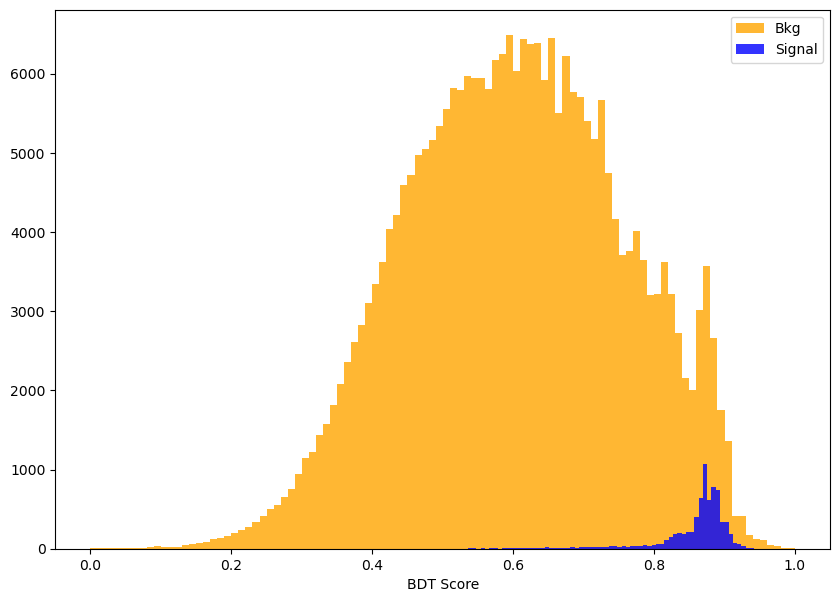

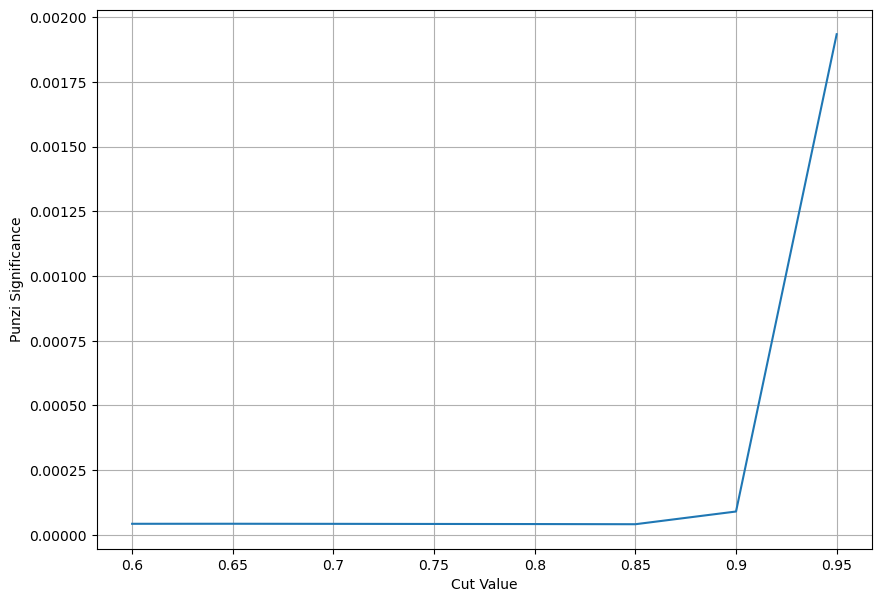

Val: 1500
Model: B


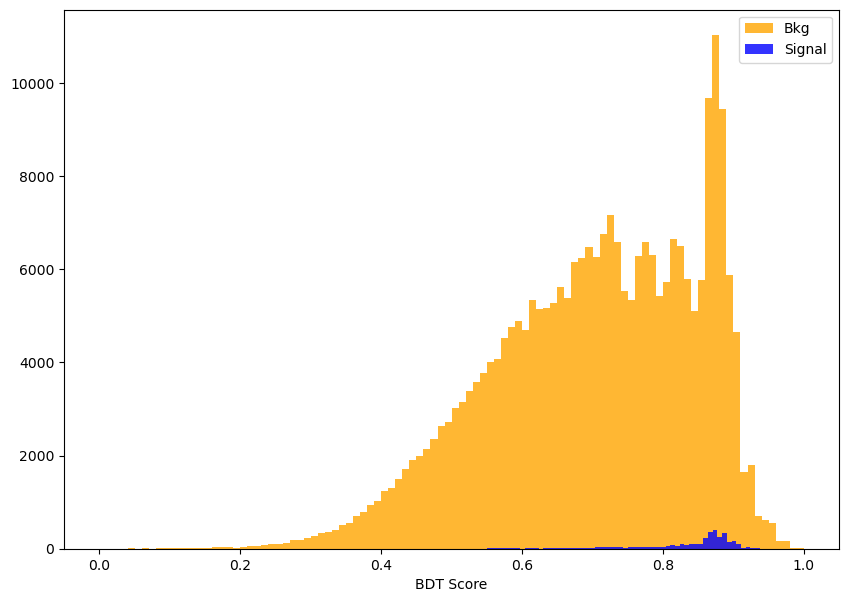

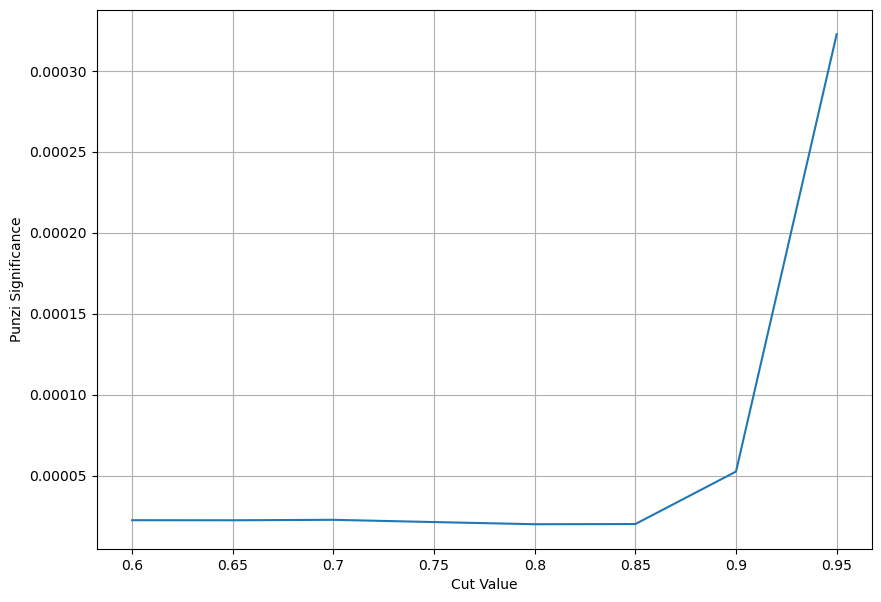

Val: 1500
Model: C


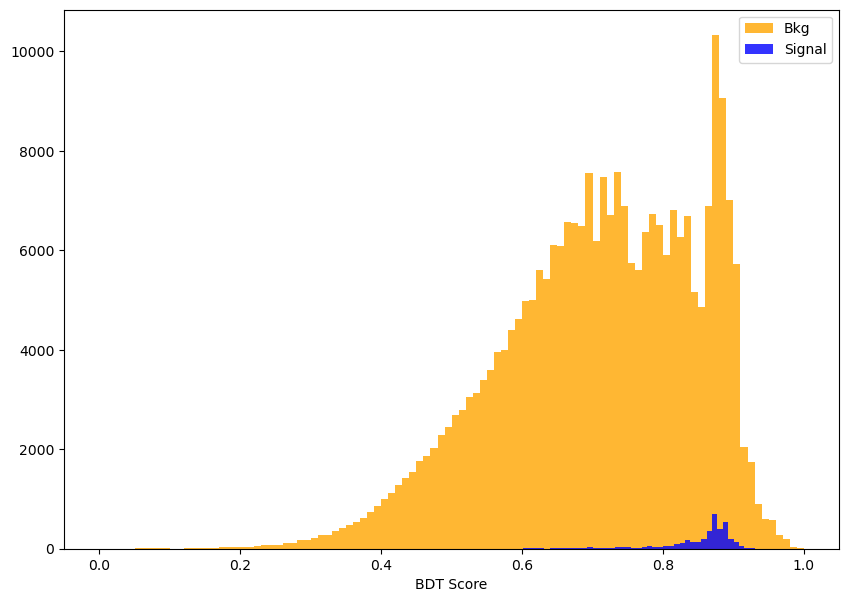

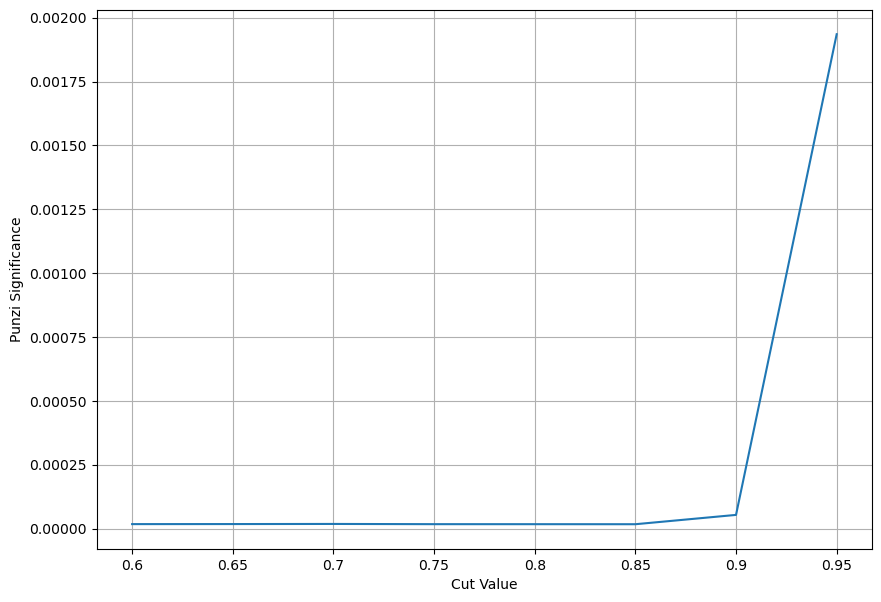

Val: 1500
Model: D


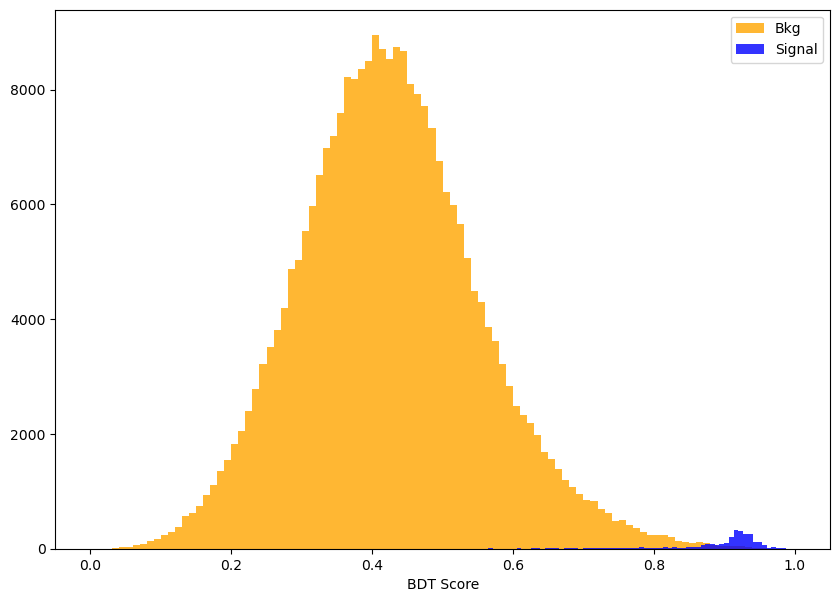

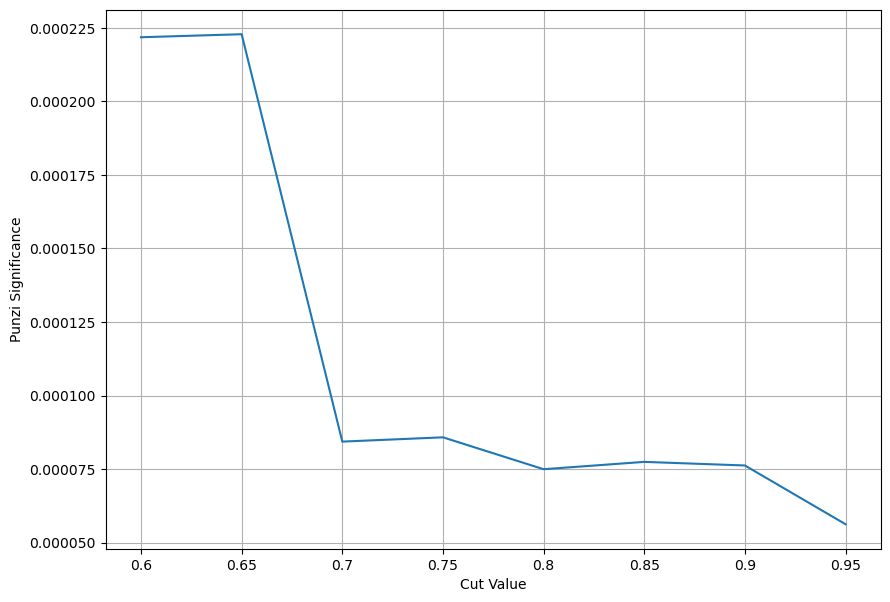

Val: 1750
Model: A


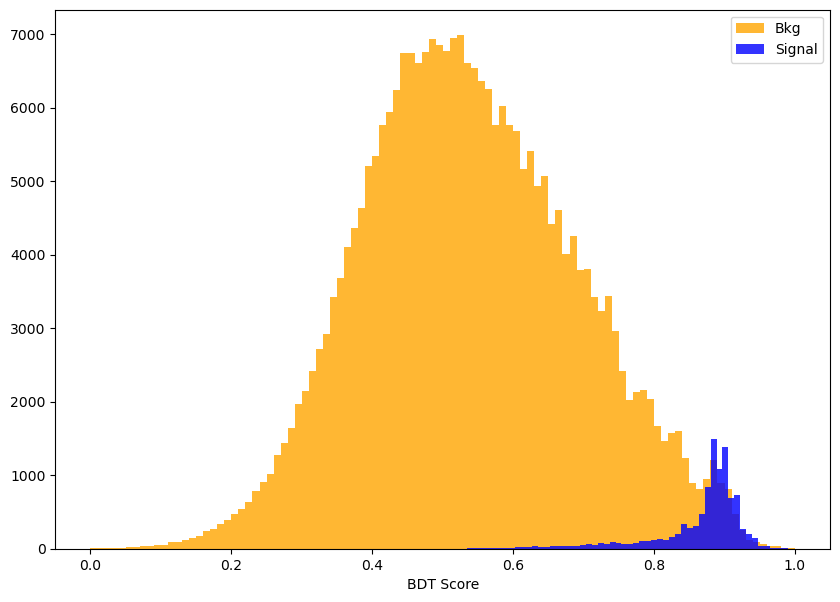

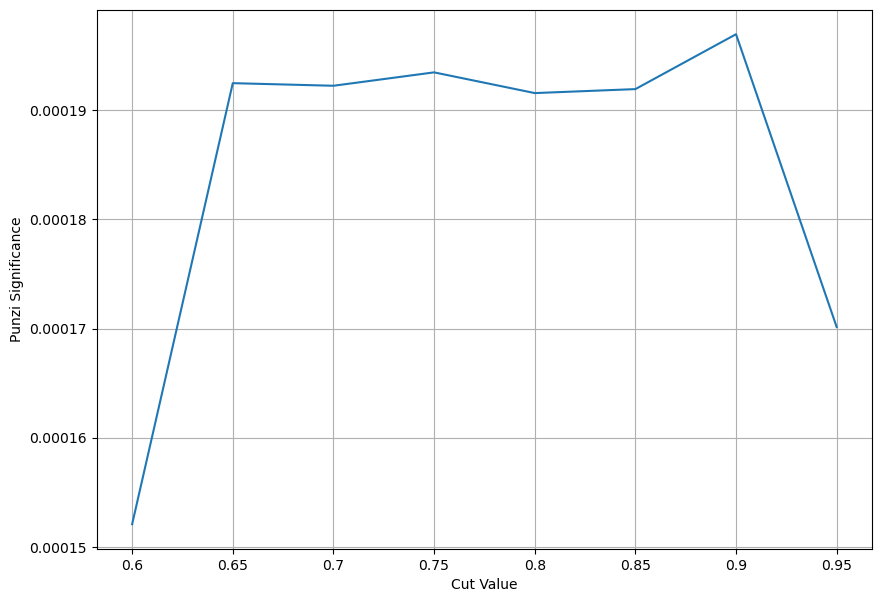

Val: 1750
Model: B


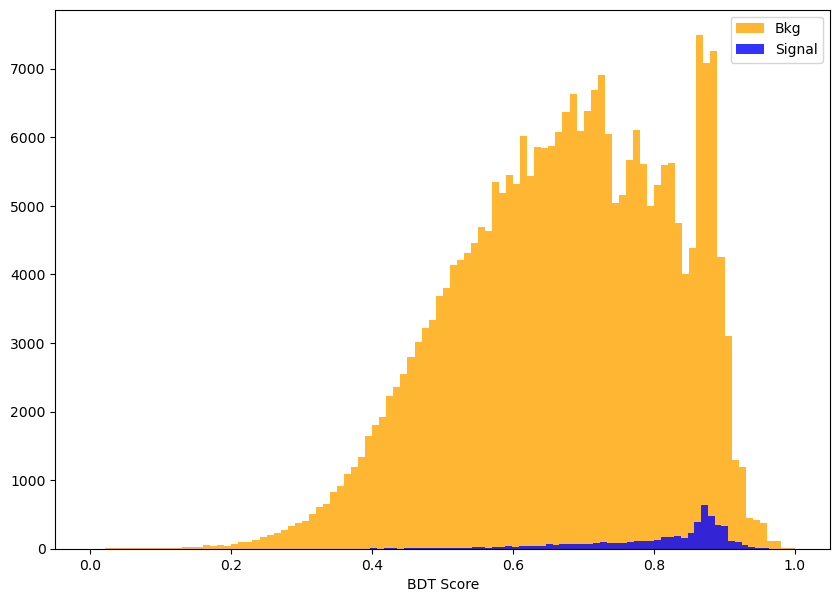

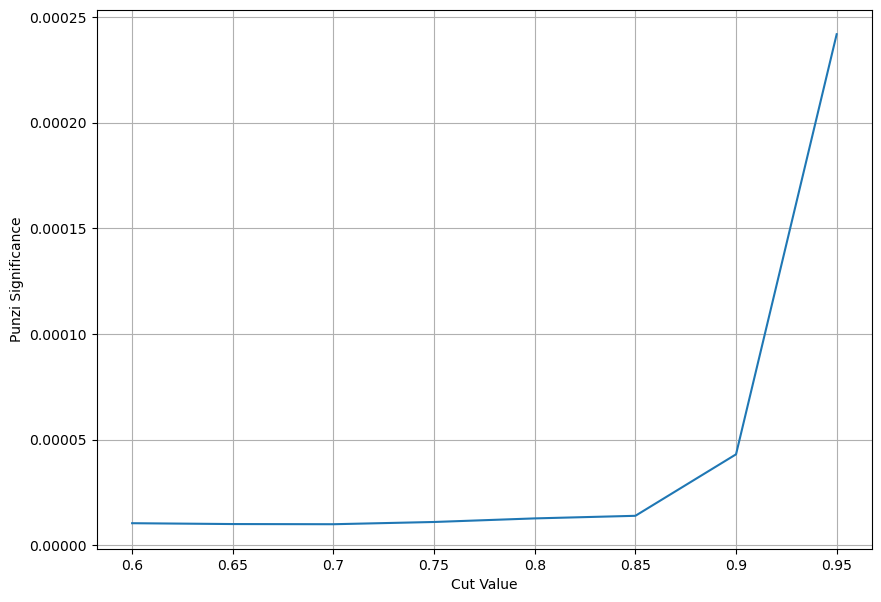

Val: 1750
Model: C


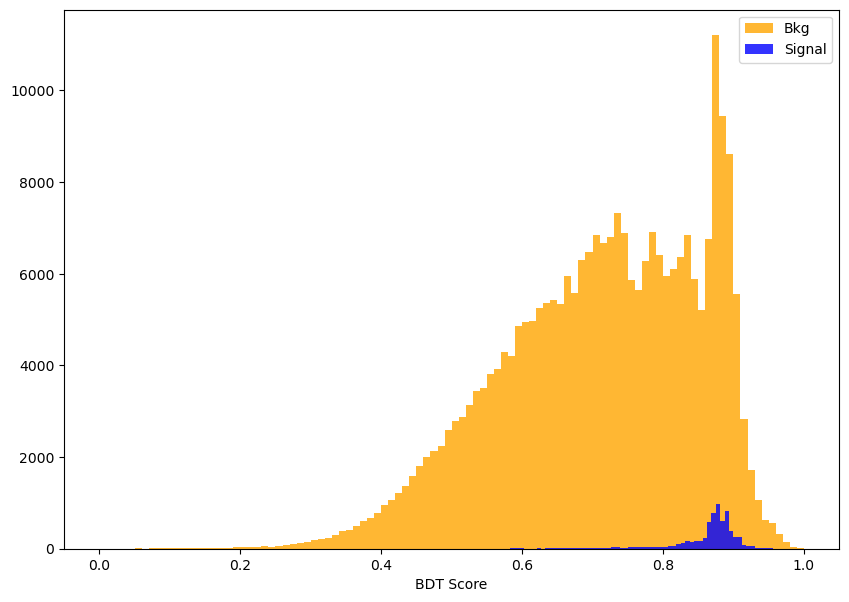

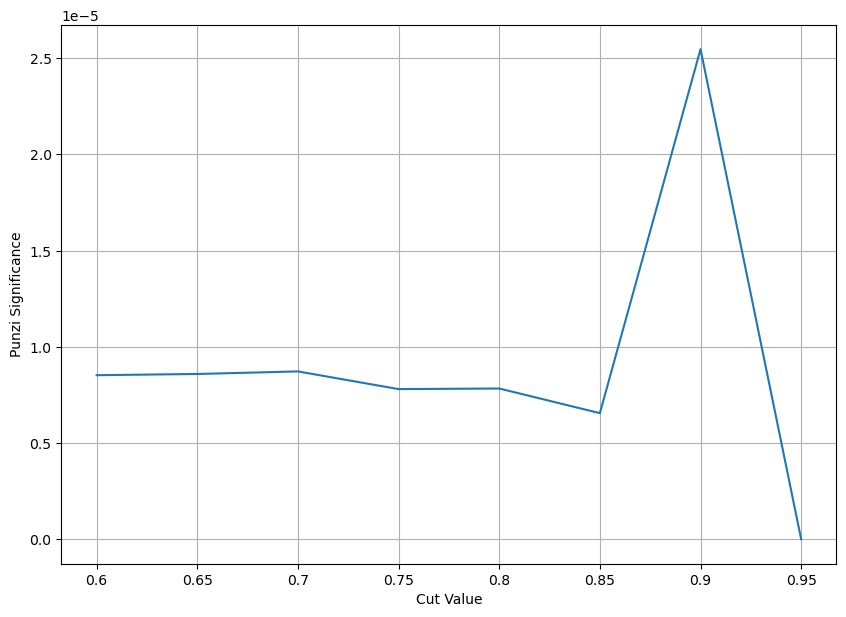

Val: 1750
Model: D


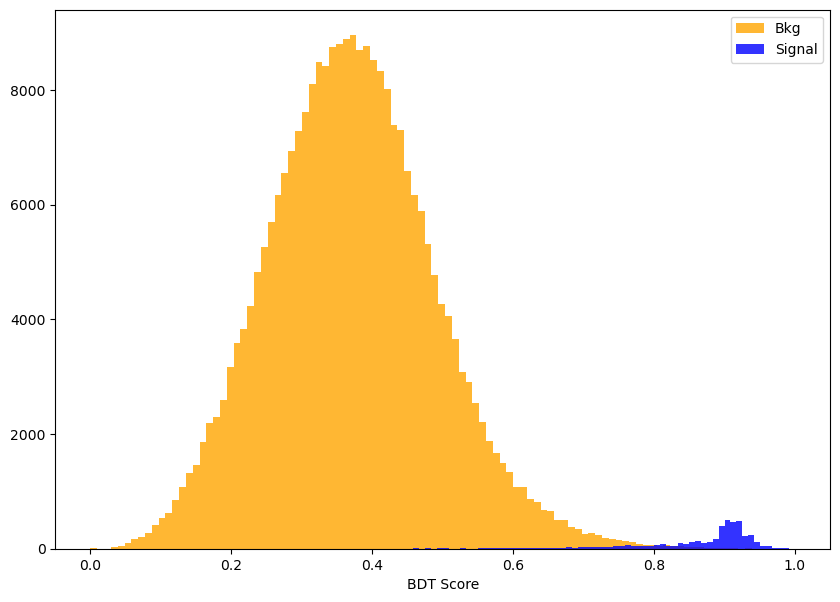

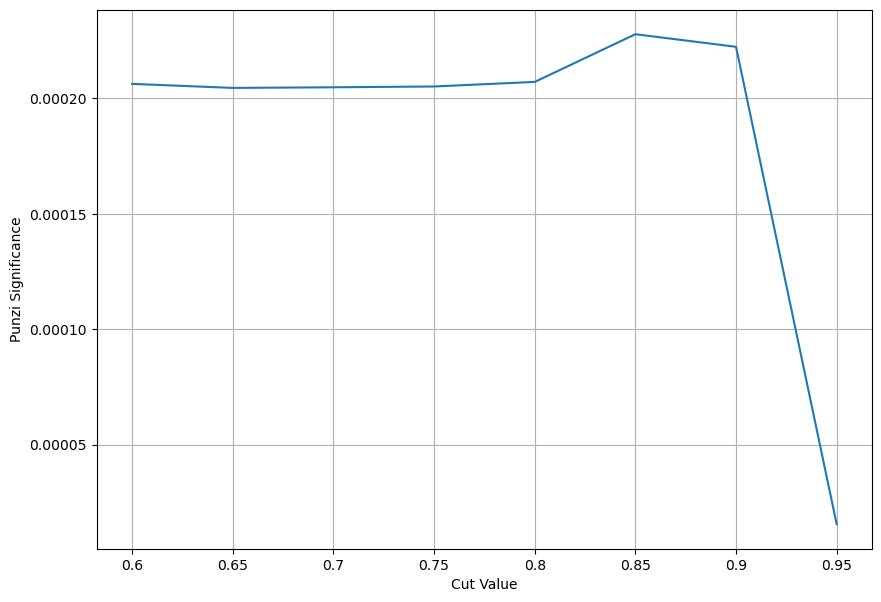

Val: 2000
Model: A


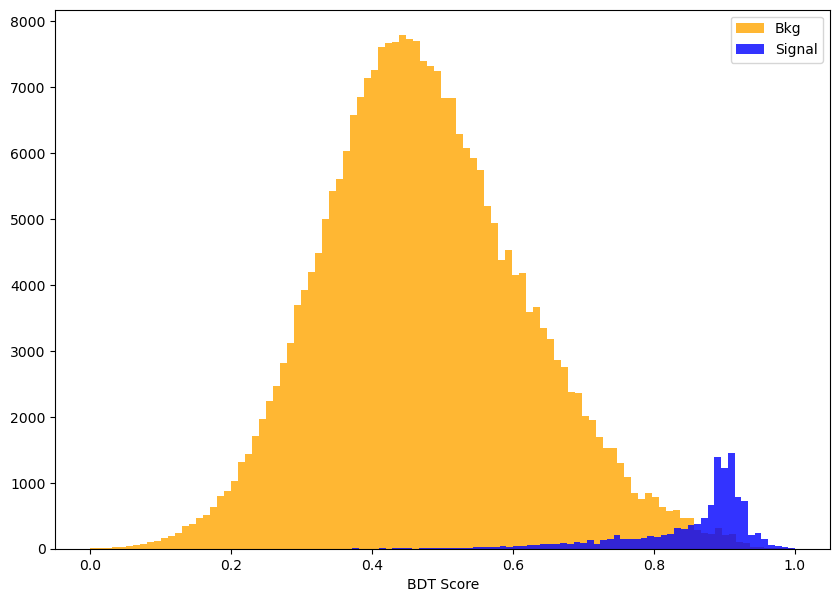

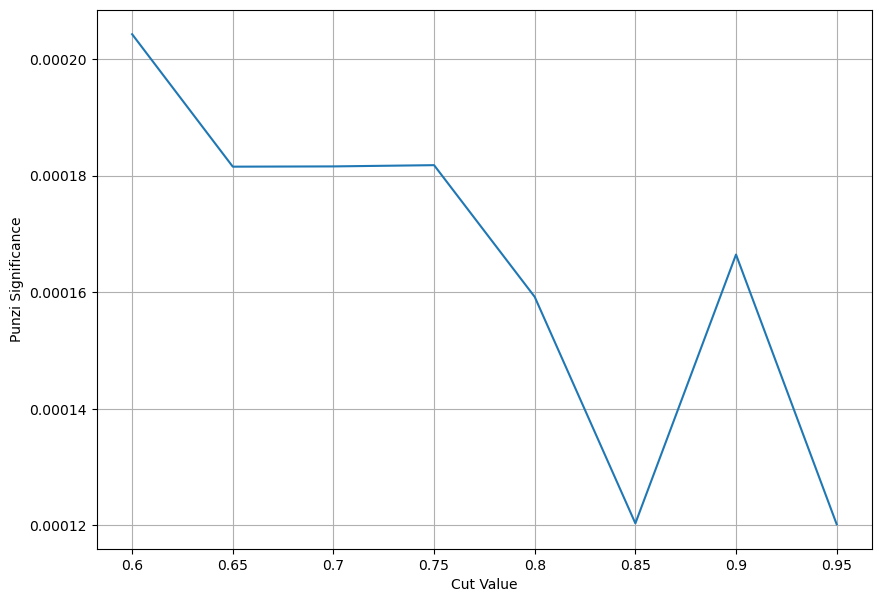

Val: 2000
Model: B


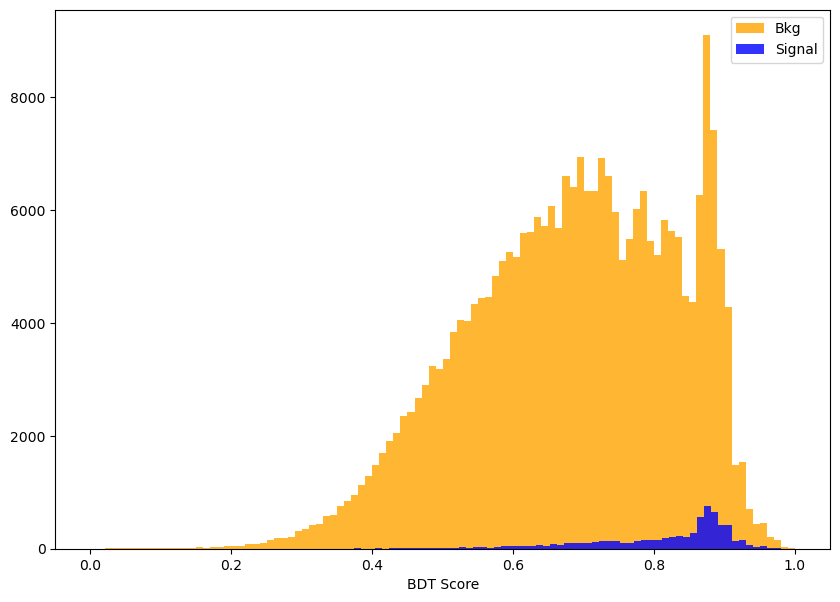

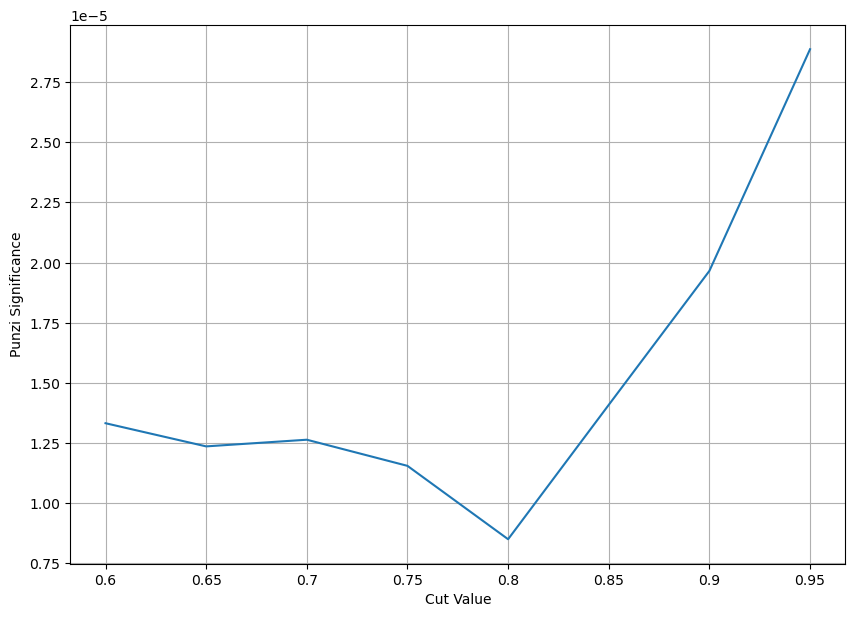

Val: 2000
Model: C


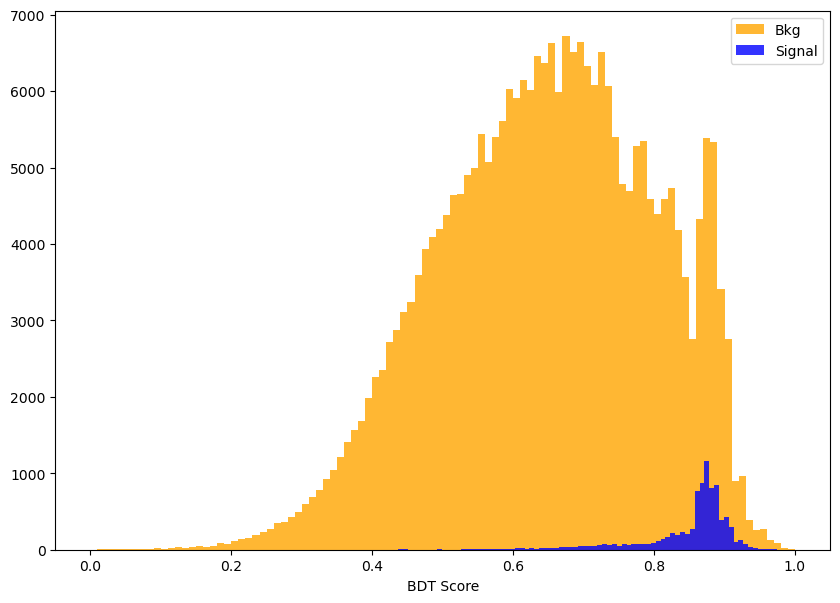

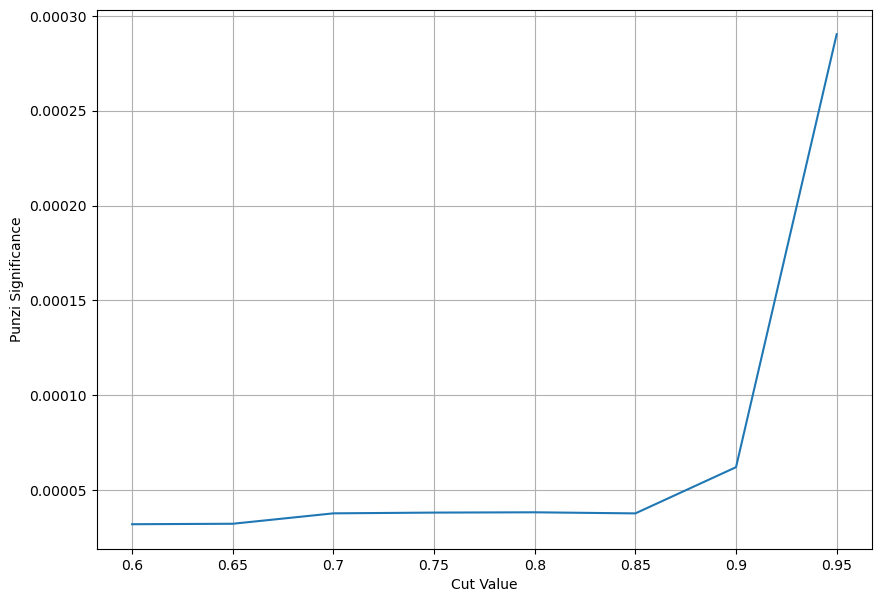

Val: 2000
Model: D


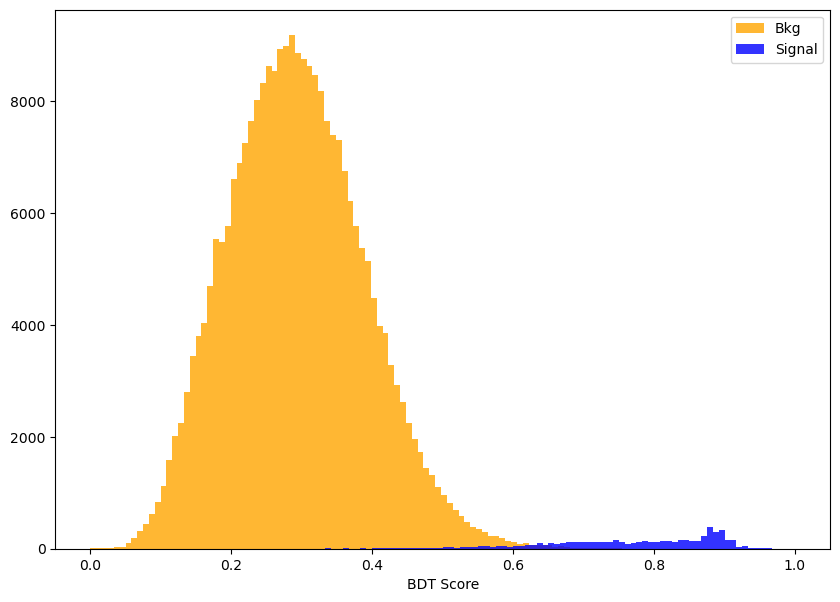

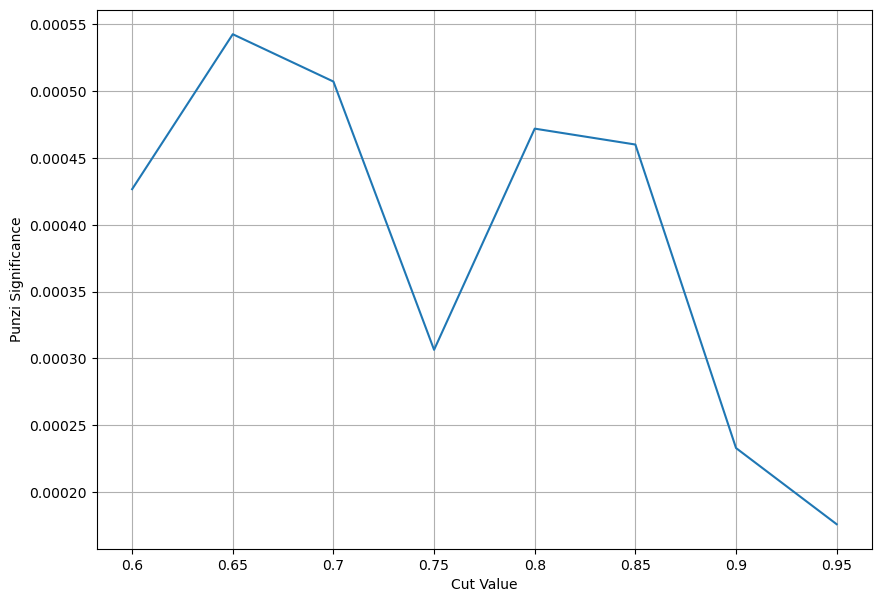

Val: 2250
Model: A


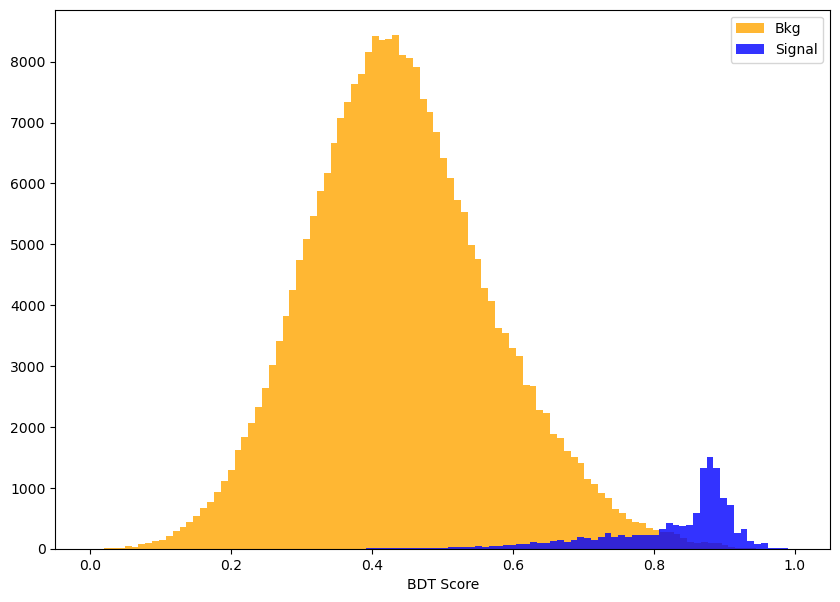

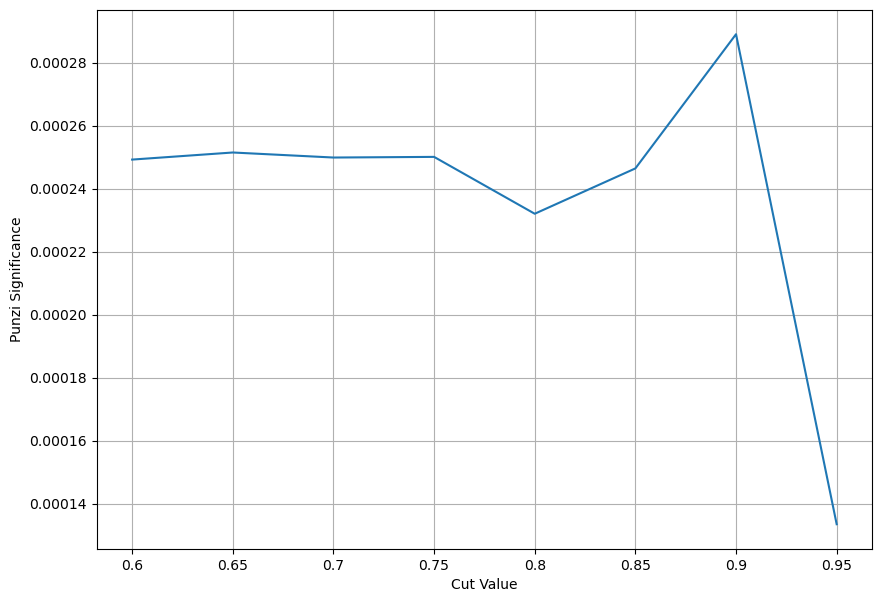

Val: 2250
Model: B


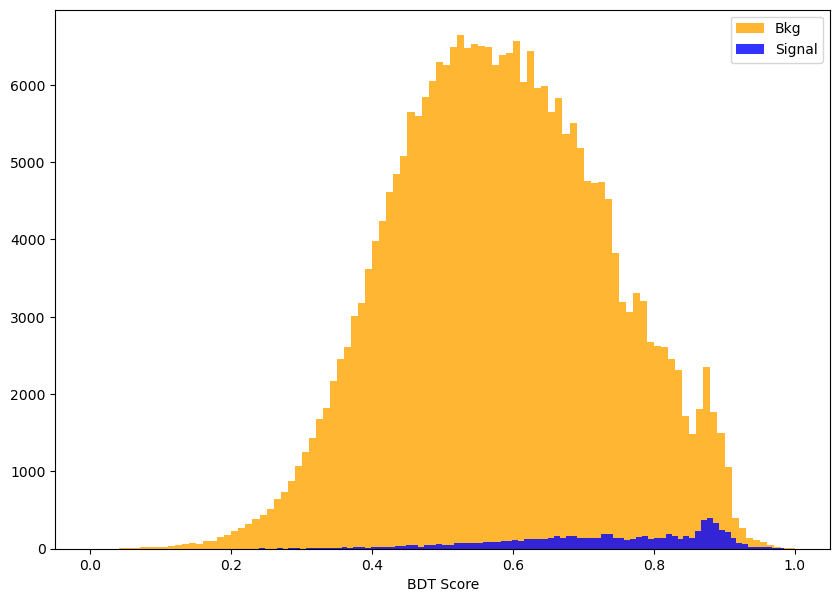

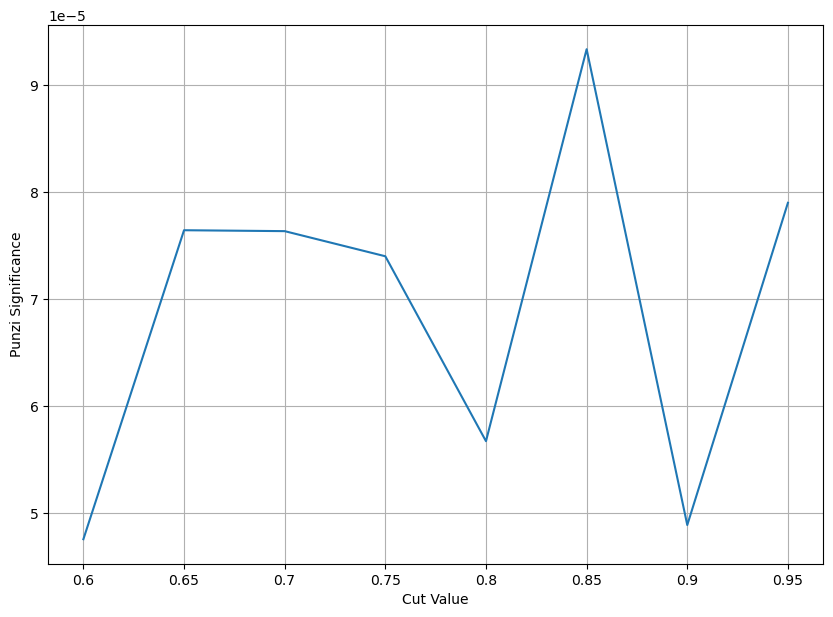

Val: 2250
Model: C


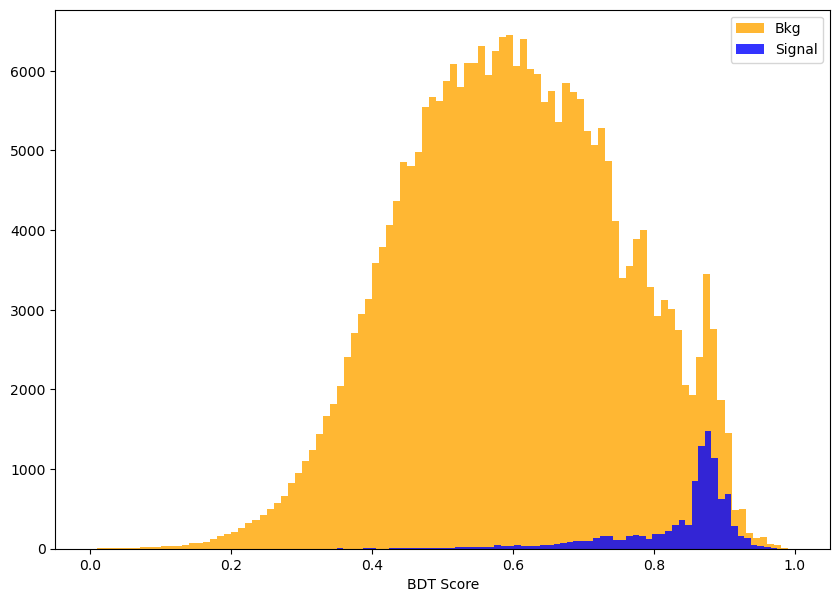

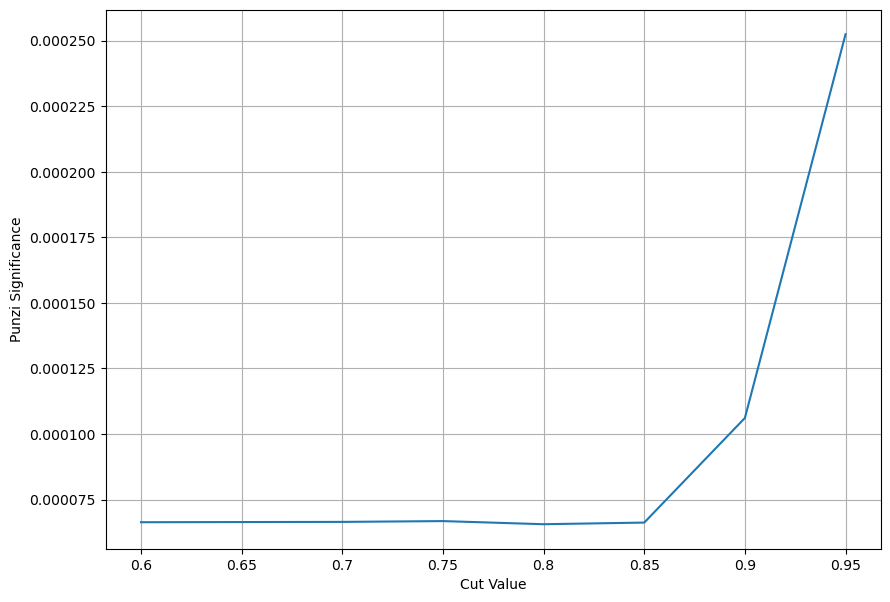

Val: 2250
Model: D


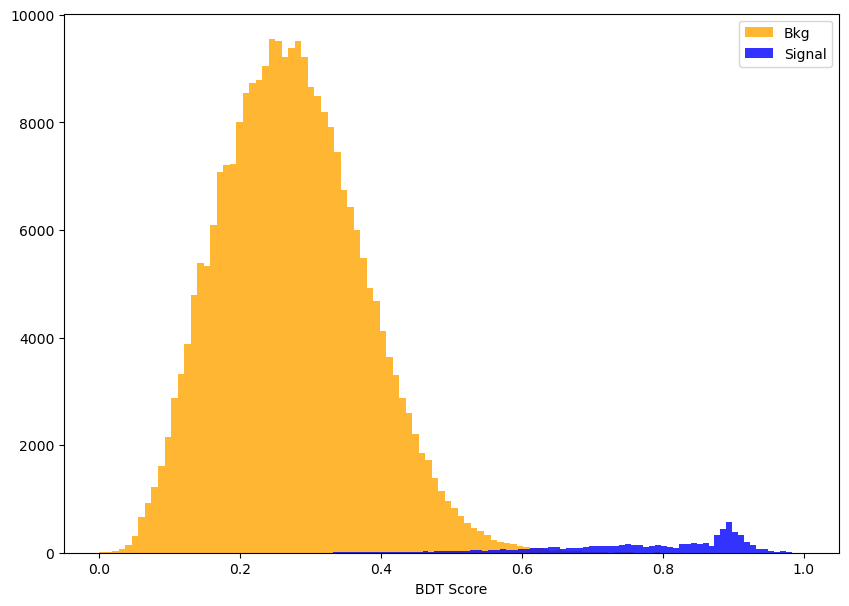

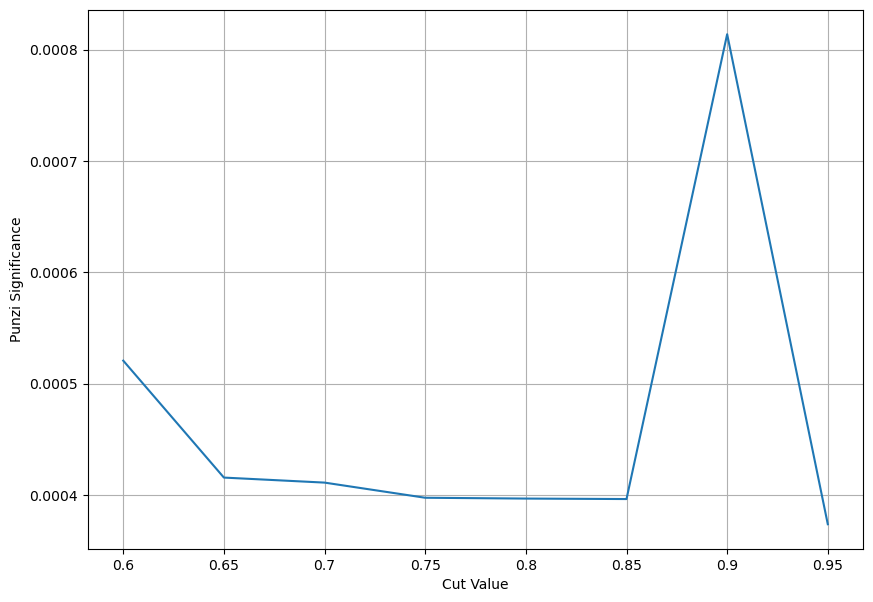

Val: 2500
Model: A


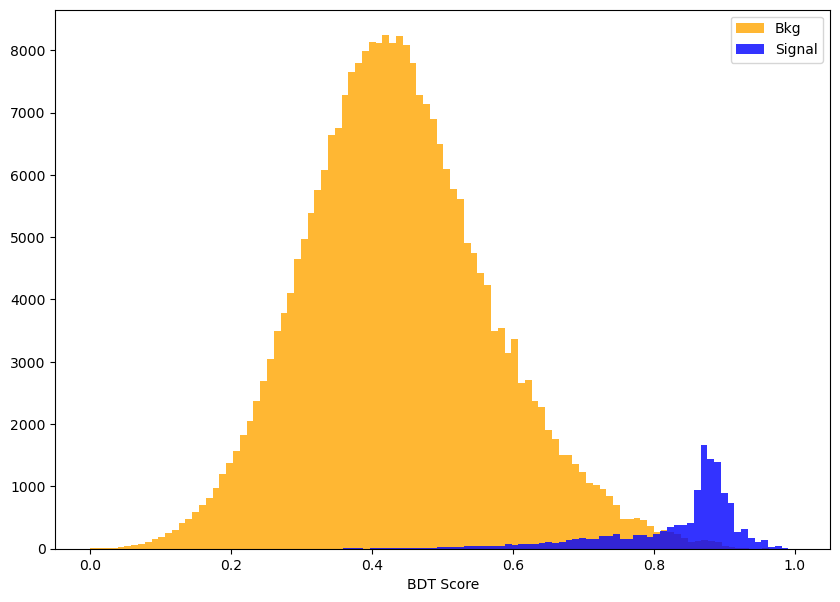

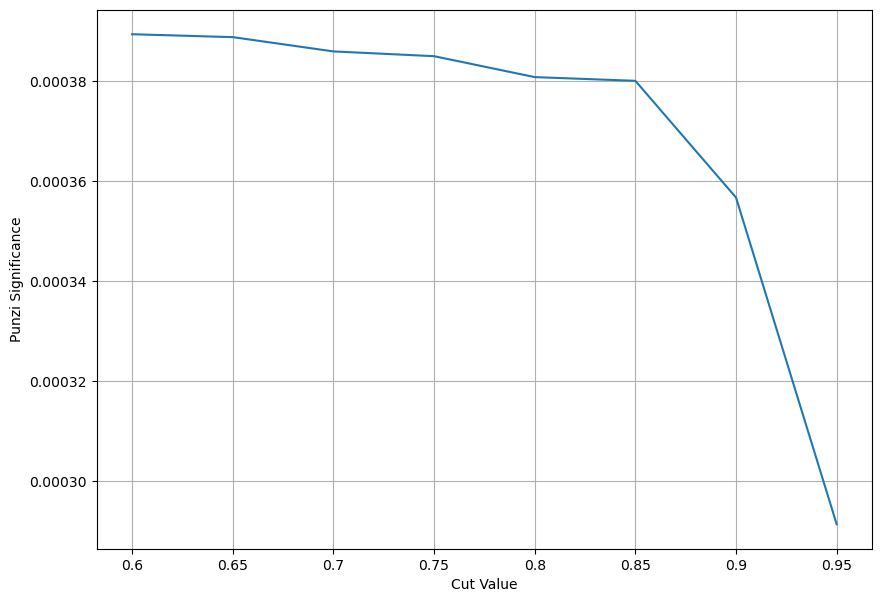

Val: 2500
Model: B


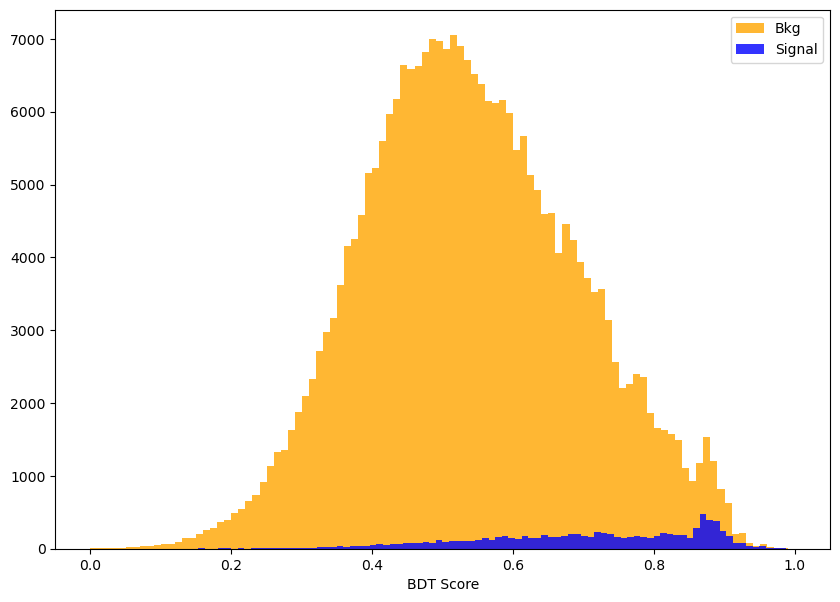

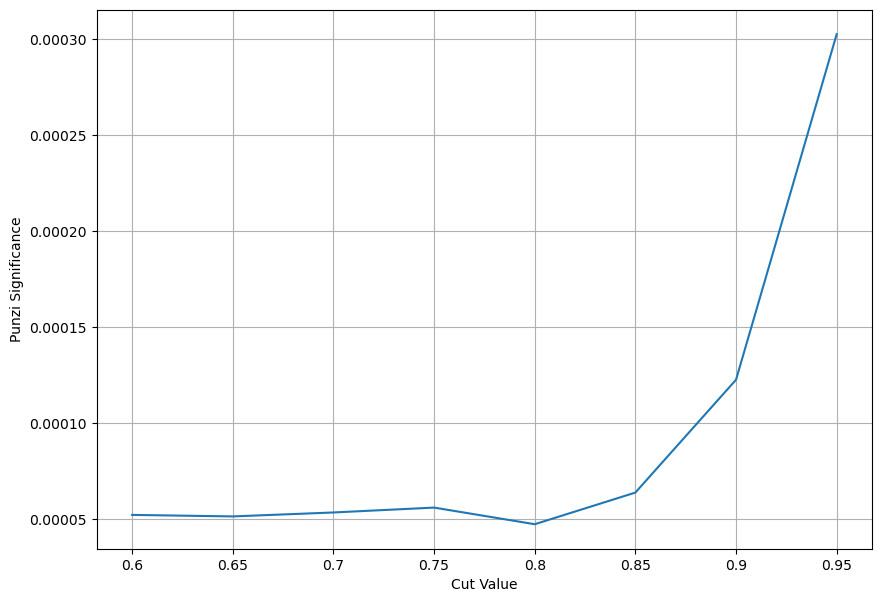

Val: 2500
Model: C


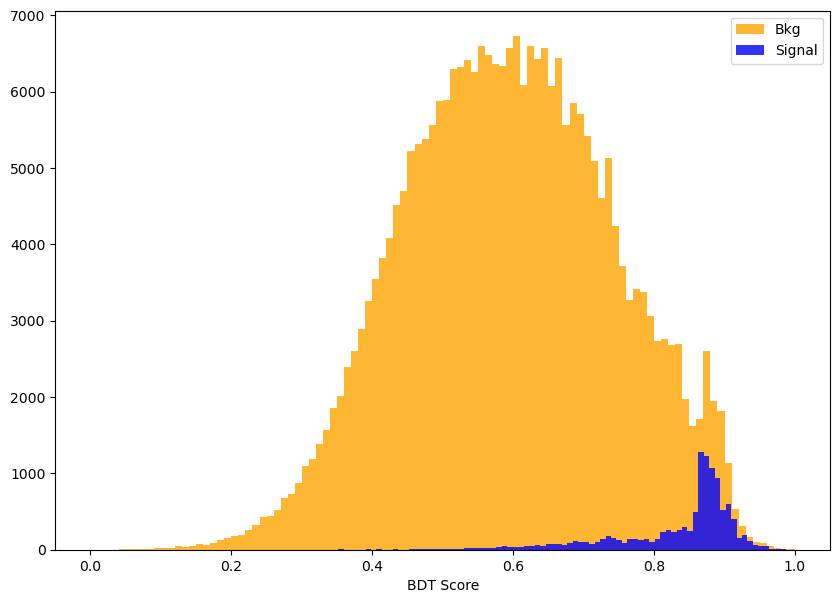

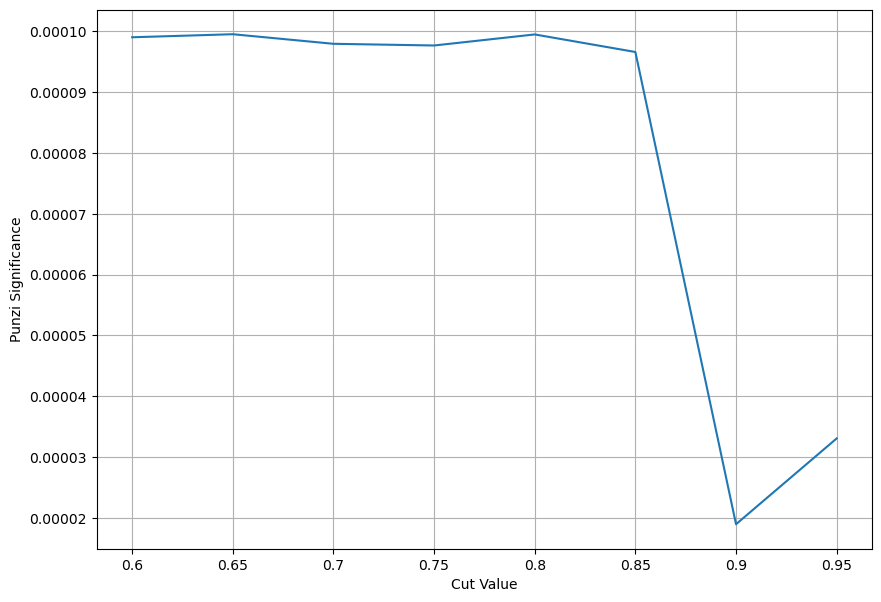

Val: 2500
Model: D


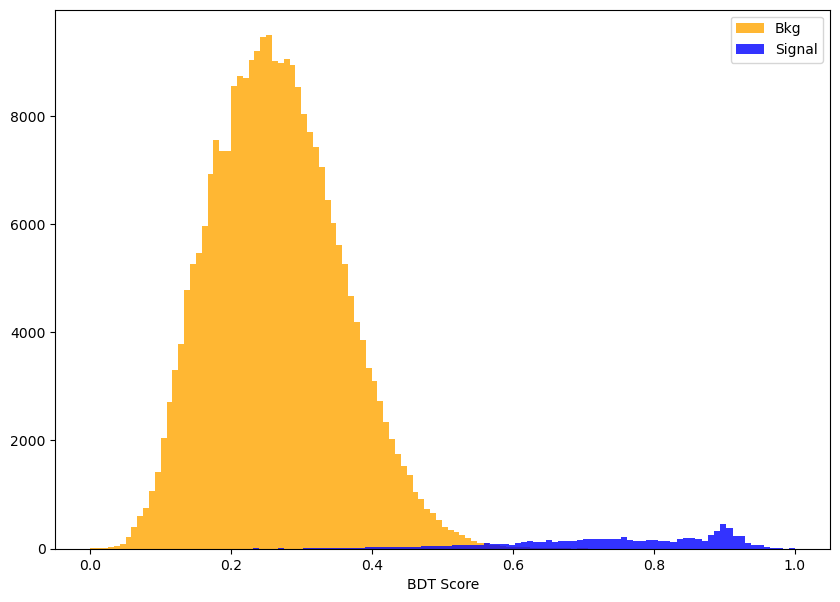

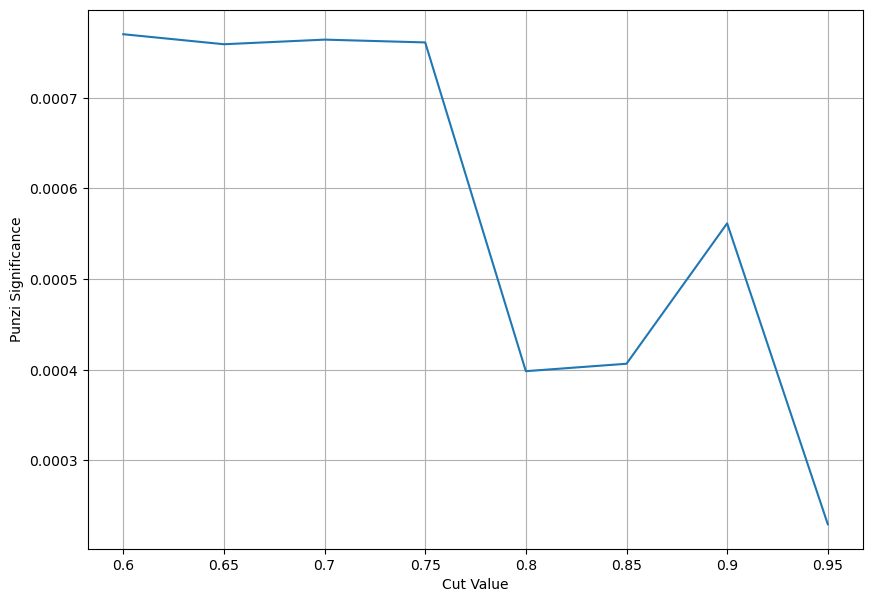

Val: 3000
Model: A


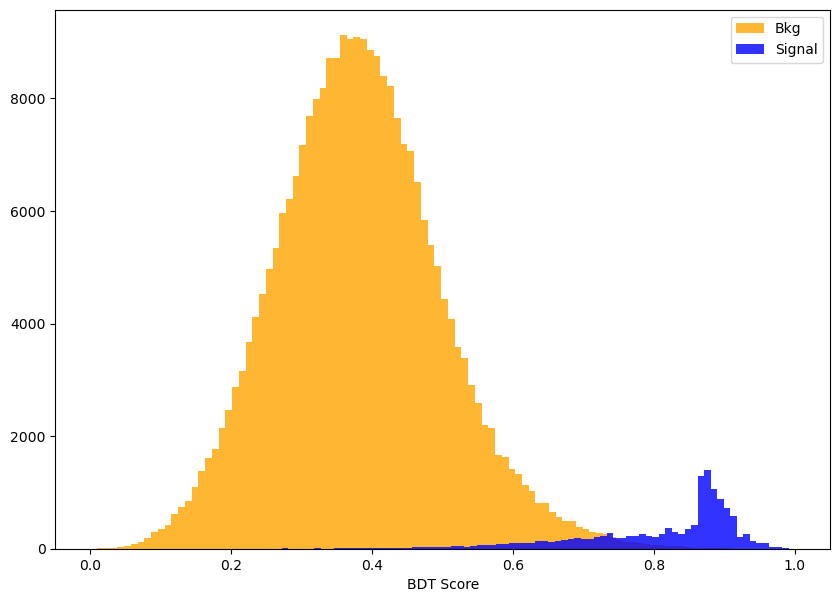

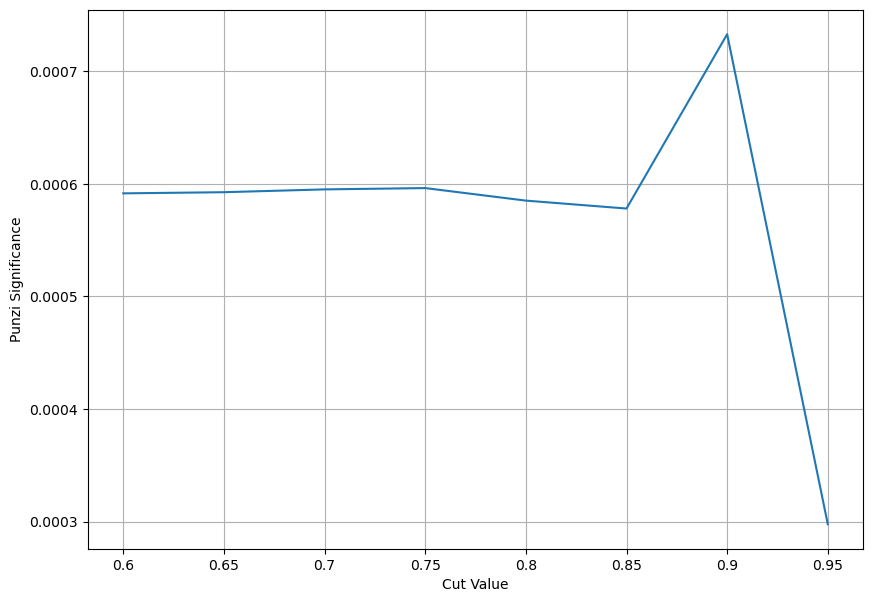

Val: 3000
Model: B


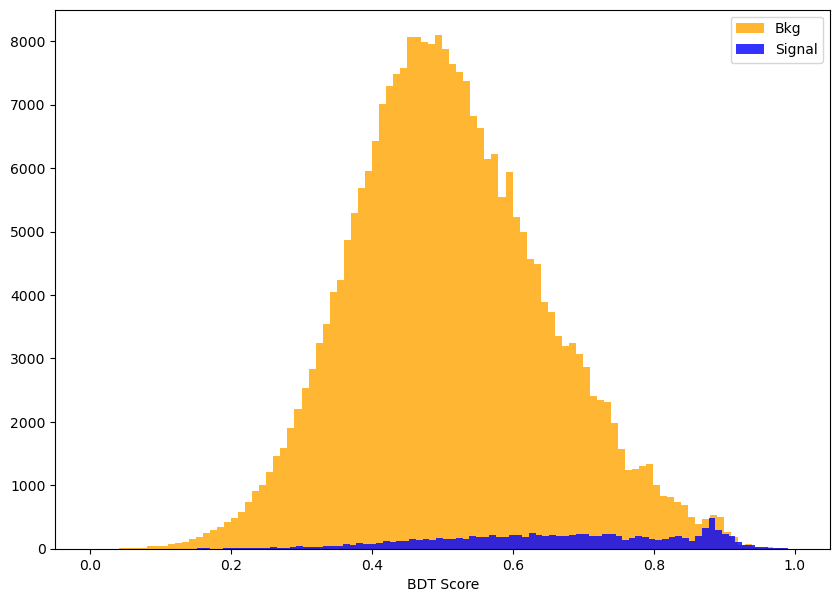

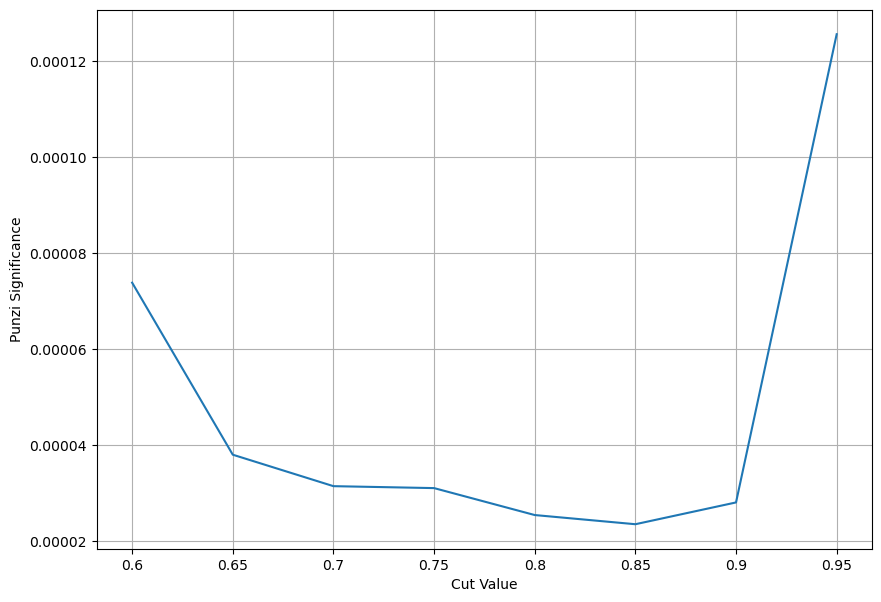

Val: 3000
Model: C


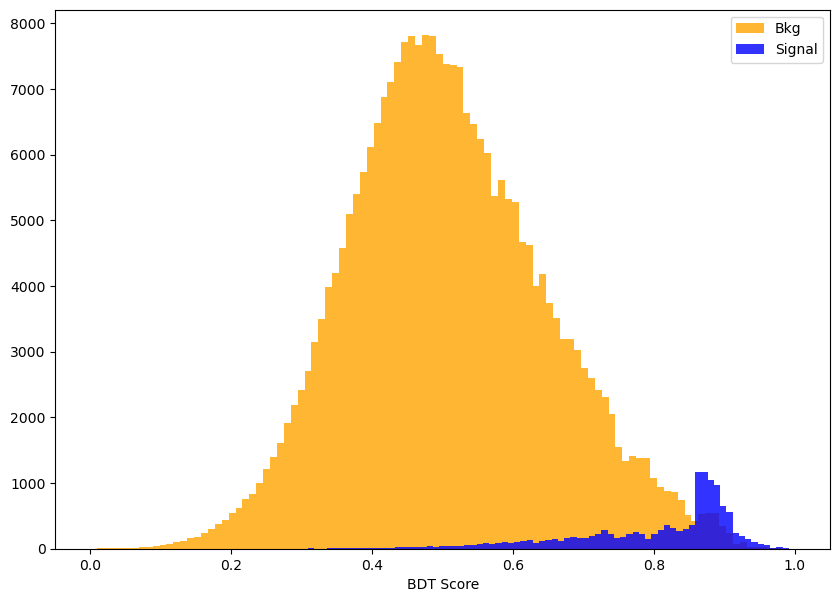

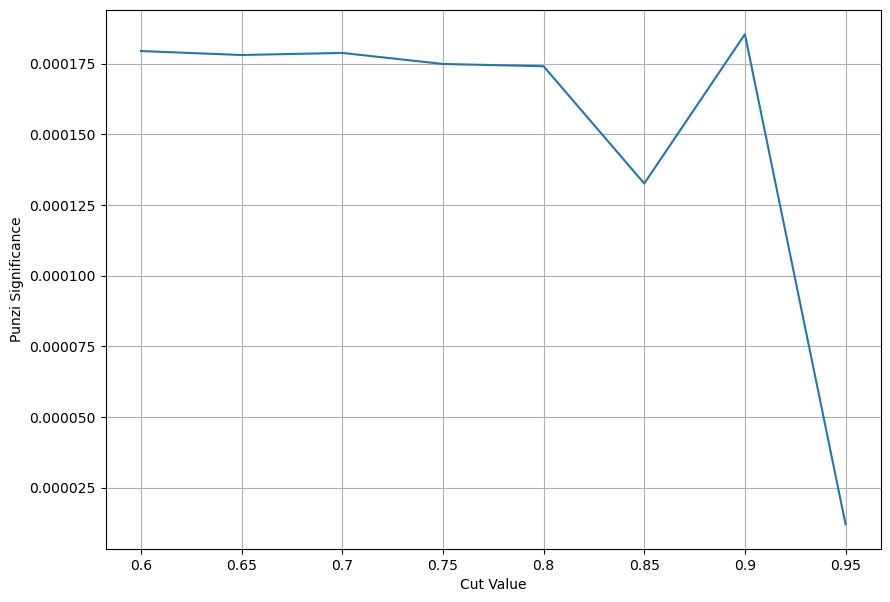

Val: 3000
Model: D


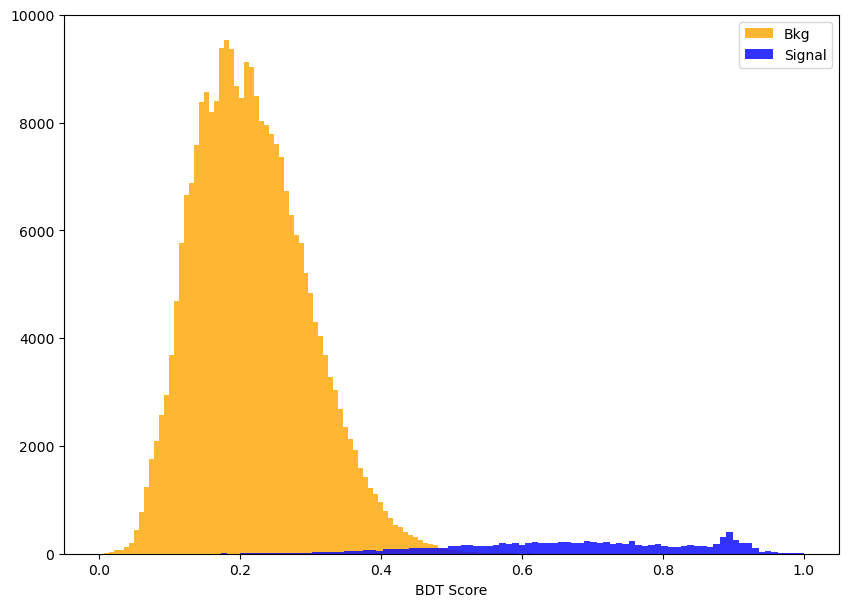

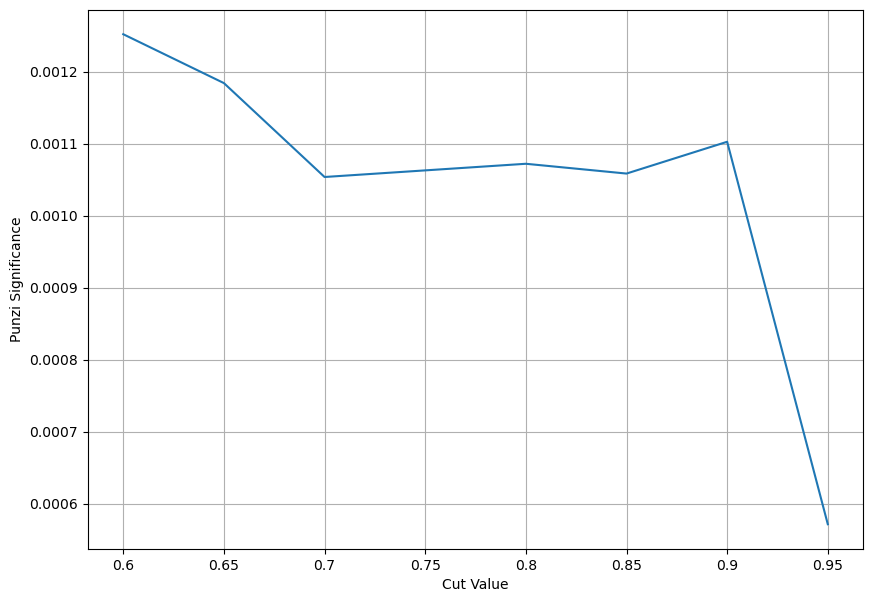

Val: 3500
Model: A


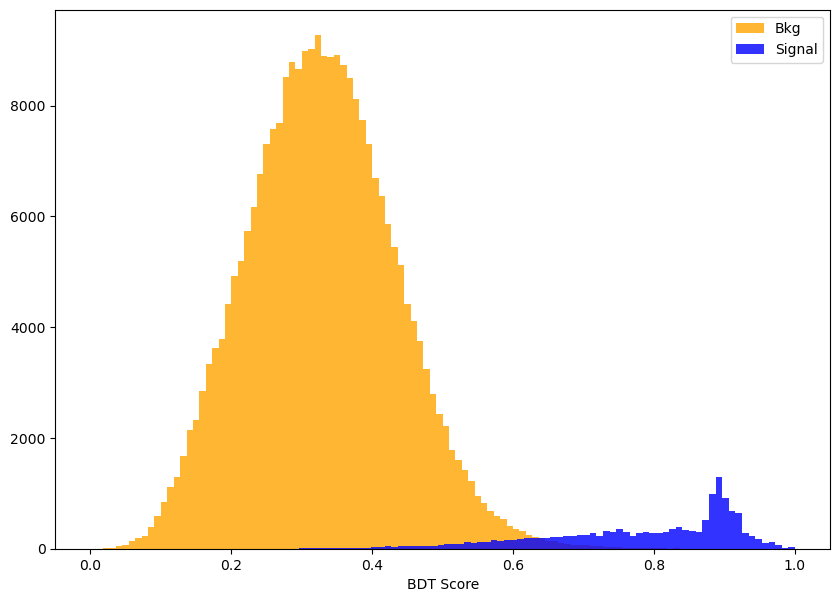

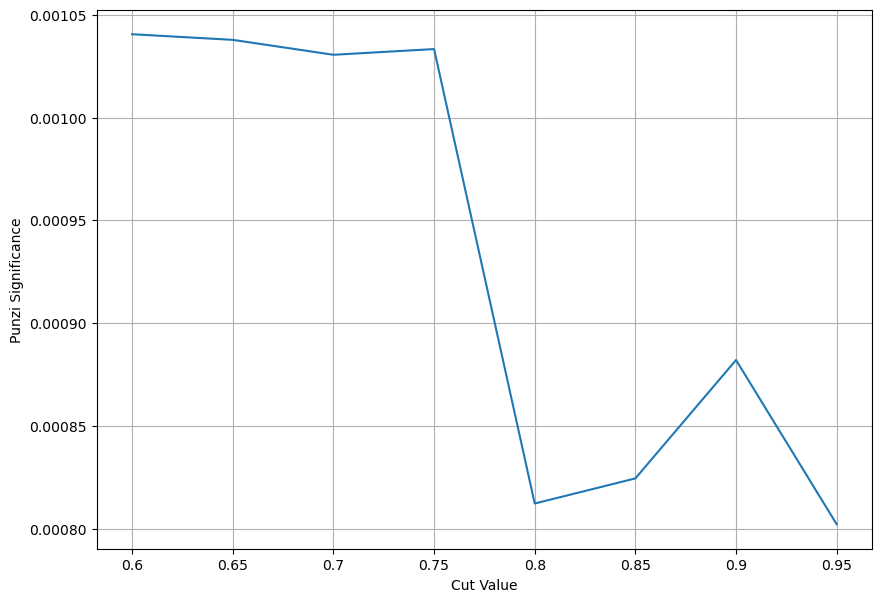

Val: 3500
Model: B


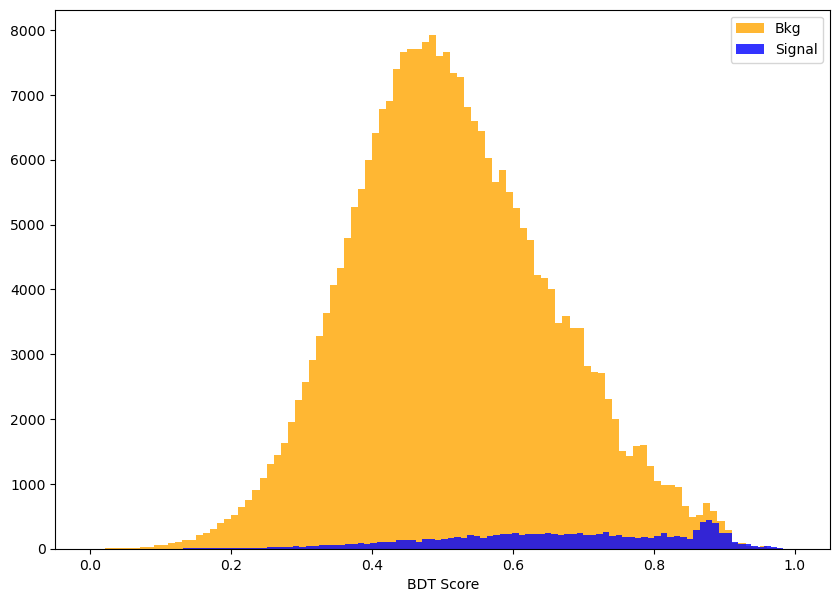

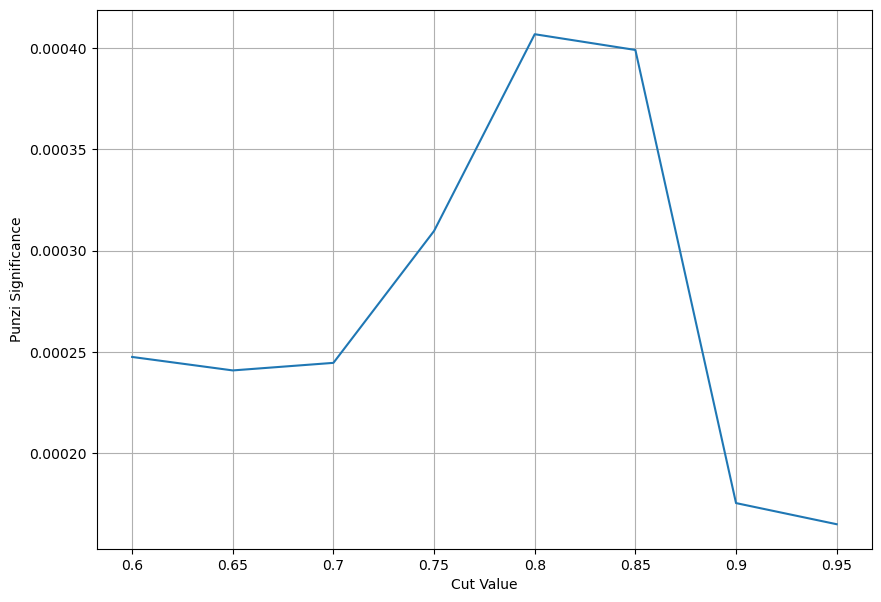

Val: 3500
Model: C


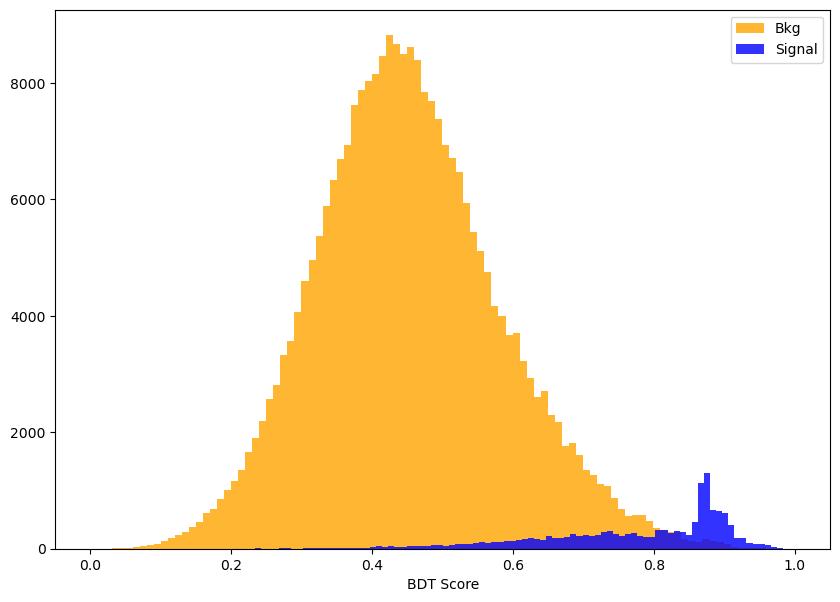

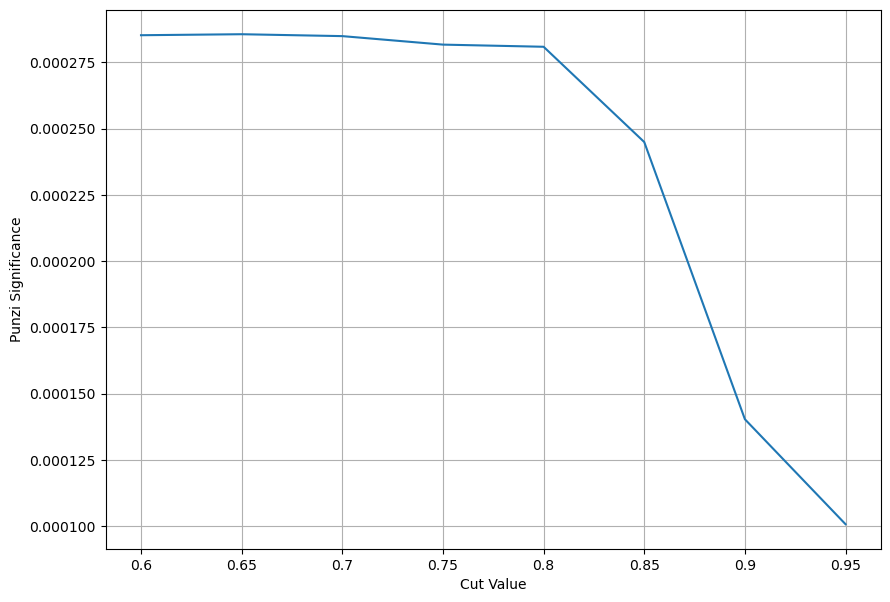

Val: 3500
Model: D


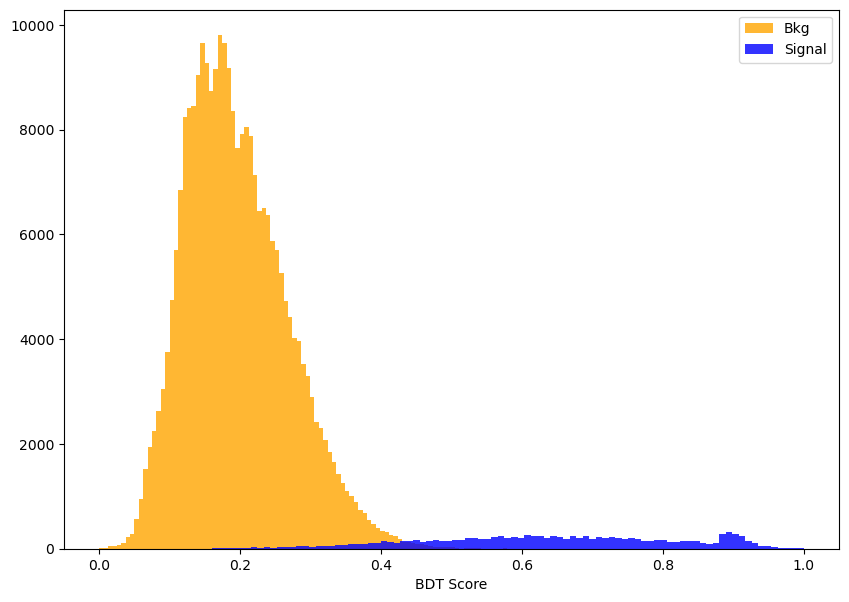

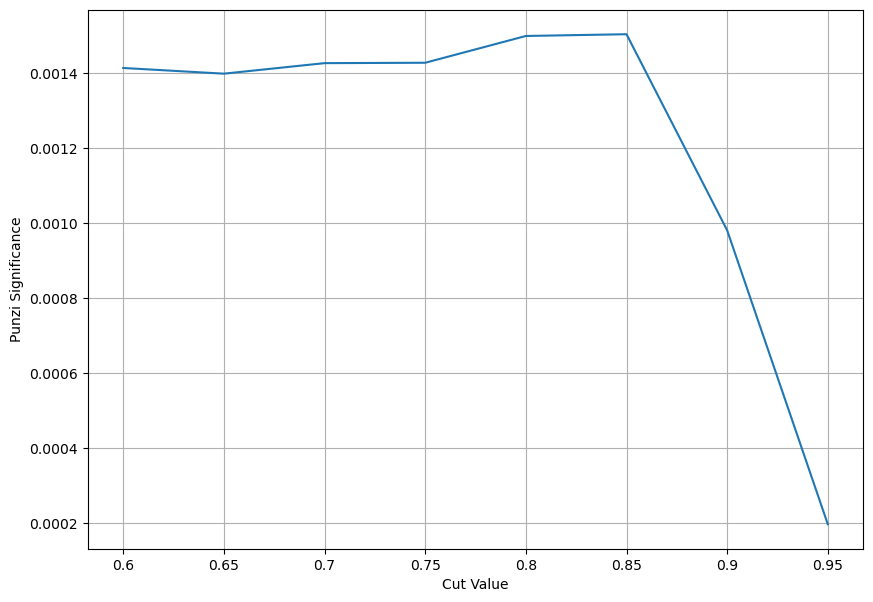

In [13]:
fourxseven()